# Importing Relevant Libraries

In [ ]:
!pip install pymc_bart

In [1]:
from tqdm import tqdm

import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

import pytensor.tensor as pt
import scipy.stats as st
import xarray as xr
import pymc_bart as pmb

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

# 1. Studying eAthlets Willingness to Pay


## 1.1. Data Preprocessing


In [2]:
# On average over the month of April, it took 1.096751 dollars or 0.882440 punds or 88.776227 russian rubles to get 1 euro, source: https://www.x-rates.com/average/?from=EUR&to=GBP&amount=1&year=2023
# we are assuming that whoever specified a value above 100 must have digited it wrongly, e.g. 800 we report it as 80. 
cd = 1.096751
cp = 0.882440
cr = 88.776227
cdic = {'200':20/cd, '40':40/cd, '250':25/cd, '35':35/cd, '20':20/cd, '2500':25/cd, '30':30/cd, '3':3/cd, '15':15/cd, '0':0, '10':10/cd, '8':8/cd, '5,00':5/cd,
 '20.00':20/cd, '2':2/cd, '5':5/cd, '80':80/cd, '400':40/cd, '1':1/cd, '100':100/cd, '7.99':7.99/cd, '10.00':10/cd, '0.0':0, '60':60/cd, '50':50/cd, '450':45/cd,
 'Idk':np.nan, '£20 to £25':23/cp, '15$':15/cd, '300$':30/cd, '20 usd':20/cd, '10 USD':10/cd, '5 ':5/cd, '30€':30, '£22':22/cp, '1-3 dollar ':2/cd, '0.50€':0.5, 
 'It needs to be covered by insurance ':np.nan, 'up to 10 euros':10, "Really depends on what I'm suffering from":np.nan, '$15/month':15/cd, '$20':20/cd,
 'Monthly sub is ridiculous, bill per consultation and if it exceeds N per month charge a monthly rate':np.nan, '5 usd':5/cd, 'USD 5-10':7.5/cd, '$0 ':0,
 '$5':5/cd, '0 one time fee only':np.nan, '25 €':25, '$1-3 / month':2/cd, '50$':50/cd, '25 dollars':25/cd, '10 dollars':10/cd, '£10':10/cp, '$100':100/cd,
 '15/month':15/cd, '5 dollars':5/cd, 'Probably not a lot':0, 'Unsure':np.nan, '$10':10/cd, '75':75/cd, '4.99':4.99/cd,
 '12 usd. 15+ usd if there was a promise that I would not need a long term subscription since my problems would be fixed':12/cd, 
 'Why would I pay when it’s supposed to help the physicians?':0, '£5-£10':7.5/cp, 'Little to none':0, '10$':10/cd, '2 euro/dollars':2, 'No idea ':np.nan,
 'As a casual - 30$, but pros might do 80 and upwards':30/cd, '$20 CAD':20/cd, '25$':25/cd, '$10-$20':15/cd, '$50':50/cd, '49':49/cd,
 'Around 20-30 dollars i guess, that would be a reasonable price':25/cd, '$10-15':12.5/cd, '5$':5/cd, 'Wouldn’t buy one':0, '$9':9/cd,
 "I can't even get help now b/c america's healthcare system doesn't cover anything, so idk how you want this answered, If its not covered by insurance I can't get it.":0,
 "would not pay, this is not something that is useful for a consumer - even with the data a general practionist doctor isn't going to be able to help much. They don't listen much as is and don't give particularly good advice - you have to go to a specialist already and they'll have their own way of doing things and may not care or use the data at all. This is something that would have to be issued from a specialist, not something you buy as a patient or consumer and expect to get any value from.":0,
 '5-8 euro':6.5, '20 a month ':20/cd, '45':45/cd, 'N/a':np.nan, '5€':5/cd, '0£':0, '1 dollar ':1/cd, '£80':80/cp, "i don't think I would at all, i hate subscriptions, maybeee for free":0,
 "If I were a professional gamer I'd pay up to $100/month":100/cd, 'So you want people to pay you monthly, so you can install what is essentially a virus on their PC? LMAO good luck with that':0,
 '$5 usd':5/cd, '$5.00':5/cd, '5.99':5.99/cd, '50€':50, '$50.00':50/cd, '0.99':0.99/cd, '$15':15/cd, '£20':20/cp, '£5.99':5.99/cd,'unsure':np.nan, '2.99':2.99/cd,
 '0€':0, '£0':0, '$7.99 without personalized care':7.99/cd, '5.00':5/cd, '8$':8/cd, '10USD':10/cd, '25 CAD':15/cd, '3usd':3/cd, '6,99':6.99, '5-10 usd':7.5/cd,
 '$2.99':2.99/cd, '50-100$':75/cd, '5-10':7.5/cd, 'fuck subscription requirements':0, '4,99':4.99/cd, 'i probably wouldn’t pay for it':0, 'About a dolar':1/cd, 'Around $5 USD':5/cd,
 '$0':0, 'Something like this sounds like the perfect FOSS software to be honest. If you want money, you can still accept donations. You can check out awesome github privacy if you are interested in learning more about FOSS softwares':0,
 '2$':2/cd, '10/15 pounds':12.5/cd, '4$':4/cd, '20$':20/cd, '25usd':25/cd, "I can't afford to pay at this time, if I had means, maybe 10 to 20":15/cd, 'not sure':np.nan,
 '10€':10, '€5/month':5/cd, '30$':30/cd, '5eur but I believe that it should be free (sold to meds/sponsored)':5, '10-15':12.5/cd, 'Maybe 50 USD (possibly lower if covered by insurance, etc)':50/cd,
 '12.99':12.99/cd, '2-4$ a month.':3/cd, '20 USD':20/cd, '5USD at most':5/cd, '10-20 dollars':15/cd, '$25':25/cd, '10-20, preferably with some free features for testing first':15/cd,
 '$15 dollars':15/cd, 'Not sure but maybe around 20-30':25/cd, '5-10usd':7.5/cd, '15 usd':15/cd, "3 usd. I like the idea but I wouldn't really use it I feel. ":3/cd, '5-15 usd':10/cd,
 '1.00':1/cd, 'I would probably not buy it I have other medical problems I can’t afford to get fixed ':0,  '0$':0, '4€':4, '7':7/cd, 'Around 200 USD':20/cd, '20 euros':20, '$15-20':17.5/cd,
 '3-6 pounds ':4.5/cp, '1500₽':1500/cr, '£5':5/cp, '10 pound':10/cp, '$800':80/cd, '5 USD':5/cd, '15 pounds':5/cp, '3-5':4/cd, '3.99':3.99/cd, 'max 20/month':20/cd,
 'Personally I probably would not buy it for any price (i do not subscribe to pretty much anything) but maybe 10€/month0':10, '0.00':0, '.':np.nan, 'Five dollars or less ':5/cd, '5euros':5,
 'Unsure- very niche market that few would probably invest in. Gaming professionals or budding professionals are probably more likely to invest in their peripherals':np.nan,
 'ten dollar ':10/cd, '$0.00':0, '75-100':87.5/cd, '$25-$30':27.5/cd, 'idk':np.nan, '4':4/cd, 'Around 60':60/cd, '$3':3/cd, 'Maybe ~$10/month (USD)? Personally, I avoid subscription models at all cost. ':10/cd,
 '$8':8/cd, 'I’m not sure':np.nan, '10 usd':10/cd, '$10 a month':10/cd, "I'm not a PT so nothing":0, '$6.99':6.99/cd, 'I would not purchase it':0, '100$':100/cd, '10 euro':10, '£25':25/cp,
 '$5.00 USD/mo':5/cd, '$30':30/cd, 'As low as possible':np.nan, '$6':6/cd, '12$':12/cd, '12':12/cd, 'Nothing':0, '199.99': 20/cd, '5,-€':5, '1 eur':1,
 "I personally am heavily against subscriptions. I'd rather pay a $40-60 license once and be done with it.":5/cd, '25 bucks':25/cd, '10-5€':12.5, '-1':0, 'Not sure': np.nan, '$5-10':7.5/cd}

In [4]:
# ============================================================= IMPORT DATA =======================================================================
# Download responses as excel and import them on the left tab.
# copy its path from the three dots on the left, paste it in the read_excel command. 
df_players = pd.read_excel(r'/content/Software - Players_May 2, 2023_09.51.xlsx')

# ====================================================== DATA CLEANING AND FORMATTING ======================================================================
# Here remove irrelevant columns of metadata, columns with textual insertions, and rename remaining columns.
df_players.drop(['StartDate', 'EndDate', 'Status', 'IPAddress', 'Progress',
       'Duration (in seconds)', 'Finished', 'RecordedDate', 'ResponseId',
       'RecipientLastName', 'RecipientFirstName', 'RecipientEmail',
       'ExternalReference', 'LocationLatitude', 'LocationLongitude',
       'DistributionChannel','Q14_4_TEXT', 'Q_DataPolicyViolations', 
       'Q28', 'Q30', 'Q31', 'UserLanguage'], axis = 1, inplace = True)
df_players.rename(columns = {'S1' : 'Hours Played', 'S2' : 'Professionality', 'Q11_1' : 'Wrist Pain', 'Q11_2' : 'Hands Pain',
                          'Q11_3' : 'Elbows Pain', 'Q11_4' : 'Neck Pain', 'Q11_5' : 'Back Pain', 'Q11_6' : 'Shoulders Pain',
                          'Q34' : 'Therapist Seeked', 'Q21_1' : 'Treatment Slow', 'Q21_2' : 'Treatment Expensive', 'Q21_3' : 'Treatment Inefficient',
                          'Q21_4' : 'Treatment Standardized', 'Q23_1':'Monitoring Slow', 'Q23_2':'Monitoring Expensive', 'Q23_3':'Monitoring Inefficient',
                          'Q23_4':'Monitoring Standardized', 'Q3':'Price', 'Q4':'Purchase Probability', 'Q14':'Gender', 'Q26':'Age', 'Q6':'Education',
                          'Q7':'Household Income', 'Q13':'Employment'}, inplace = True)

# Drop the first row with descritpions, and rows with more than half columns evaluating to NaNs
df_players.drop([df_players.index[0]], inplace = True)
df_players.dropna(thresh=int(len(df_players.columns)/2), axis=0, inplace=True)

# Transform price data from string to value
df_players['Price'] = df_players['Price'].map(cdic)

# Correct {1, .. 5} entries in problem intensity of therapy segments
d = { 1 : 'Definitely not', 2 : 'Probably not', 3 : 'Might or might not', 4 : 'Probably yes', 5 : 'Definitely yes'}
for header in ['Treatment Slow', 'Treatment Expensive', 'Treatment Inefficient', 'Treatment Standardized', 'Monitoring Slow', 'Monitoring Expensive', 'Monitoring Inefficient', 'Monitoring Standardized']:
  for i in [1, 2, 3, 4, 5]:
    df_players.loc[df_players[header]==i, header] = d[i]

# Transform every 'Prefer not to say' into np.nan
for header in df_players.columns:
  df_players.loc[df_players[header]=='Prefer not to say', header] = np.nan

# =================================================================== FEATURE ENGINEERING ====================================================================
# Make Gender a three level variable and dummify it
df_players.loc[(df_players['Gender'] == 'Prefer to self-describe')|(df_players['Gender'] == 'Non-binary / third gender'),'Gender'] = 'Third gender'
df_players['Male'] = df_players['Gender'] == 'Male'
df_players['Female'] = df_players['Gender'] == 'Female'
df_players['Third Gender'] = df_players['Gender'] == 'Third gender'
for header in ['Male', 'Female', 'Third Gender']:
  df_players.loc[df_players['Gender'] == np.nan, header] = np.nan
df_players.drop(['Gender'], axis = 1, inplace = True)

# Dummify Employment Variable
df_players.loc[df_players['Employment'] == 'Other','Employment'] = np.nan
df_players['Full-Time'] = df_players['Employment'] == 'Working full-time'
df_players['Part-Time'] = df_players['Employment'] == 'Working part-time'
df_players['Unemployed'] = df_players['Employment'] == 'Unemployed and looking for work'
df_players['Homemaker'] = df_players['Employment'] == 'A homemaker or stay-at-home partent'
df_players['Student'] = df_players['Employment'] == 'Student'
df_players['Retired'] = df_players['Employment'] == 'Retired'
for header in ['Full-Time', 'Part-Time', 'Unemployed', 'Homemaker', 'Student', 'Retired']:
  df_players.loc[df_players['Employment'] == np.nan, header] = np.nan
df_players.drop(['Employment'], axis = 1, inplace = True)

# Turn Therapy Problems into Interactions with Seeked Therapy
for header in ['Treatment Slow', 'Treatment Expensive', 'Treatment Inefficient', 'Treatment Standardized', 'Monitoring Slow', 'Monitoring Expensive', 'Monitoring Inefficient', 'Monitoring Standardized']:
  df_players.loc[df_players['Therapist Seeked'] == 'No', header] = 'Definitely not' # so that it turns into 0 when categorized with order.

# Scale Purchase Probability
pdic = {'Definitely would' : 1, 'Probably would' : 0.75, 'Might or might not' : 0.5, 'Probably would not' : 0.25, 'Definitely would not' : 0}
df_players['Purchase Probability'] = df_players['Purchase Probability'].map(pdic)

# Transform strings to categorical variables (NaN becomes -1, while categories start from 0) 
# - note, 'Gender', 'Employment', has not been ordered, only categorized, 
# - While Expected Earnings, Purchase Probability, and Price have not been categorized. 
Categorical_Variables = ['Hours Played', 'Professionality',
                         'Wrist Pain', 'Hands Pain', 'Elbows Pain', 'Neck Pain', 'Back Pain', 'Shoulders Pain', 
                         'Therapist Seeked', 'Treatment Slow', 'Treatment Expensive', 'Treatment Inefficient', 
                         'Treatment Standardized', 'Monitoring Slow', 'Monitoring Expensive', 'Monitoring Inefficient', 
                         'Monitoring Standardized','Male', 'Female', 'Third Gender', 'Age', 'Education', 'Household Income', 
                         'Full-Time', 'Part-Time', 'Unemployed', 'Homemaker', 'Student', 'Retired']
for header in Categorical_Variables:
  df_players[header] = df_players[header].astype('category')

df_players['Professionality'] = df_players['Professionality'].cat.reorder_categories(['No', 'Yes'], ordered=True)
df_players['Hours Played'] = df_players['Hours Played'].cat.reorder_categories(['Less than 10 hours', '10 - 20 hours', '20 - 30 hours', 'More than 30 hours'], ordered=True)
for header in ['Wrist Pain', 'Hands Pain', 'Elbows Pain', 'Neck Pain', 'Back Pain', 'Shoulders Pain']:
  df_players[header] = df_players[header].cat.reorder_categories(['No pain', 'Slight pain', 'Significant pain'], ordered=True)
df_players['Therapist Seeked'] = df_players['Therapist Seeked'].cat.reorder_categories(['No', 'Yes'], ordered=True)
for header in ['Treatment Slow', 'Treatment Expensive', 'Treatment Inefficient', 'Treatment Standardized', 'Monitoring Slow', 'Monitoring Expensive', 'Monitoring Inefficient', 'Monitoring Standardized']:
  df_players[header] = df_players[header].cat.reorder_categories(['Definitely not', 'Probably not', 'Might or might not', 'Probably yes', 'Definitely yes'], ordered=True)
df_players['Age'] = df_players['Age'].cat.reorder_categories(['Under 18', '18-24 years old', '25-34 years old', '35-44 years old', '45-54 years old', '55-64 years old', '65+ years old'], ordered = True)
df_players['Education'] = df_players['Education'].cat.reorder_categories(['Some Primary Education', 'Completed Primary', 'Some Secondary Education', 'Completed Secondary', 'Vocational or Similar', 'Some university but no degree', 'University Bachelors degree', 'Graduate or professional degree (MA, MS, MBA, PhD, JD, MD, DDS)'], ordered=True)
df_players['Household Income'] = df_players['Household Income'].cat.reorder_categories(['Less than 25000 Euros per year', '25,000 - 49,999 Euros per year', '50,000 - 99,999 Euros per year', '100,000 - 199,999 Euros per year', 'More than 200,000 Euros per year'], ordered = True)

for header in Categorical_Variables:
  df_players[header] = df_players[header].cat.codes

# Finally, reset DataFrame index - Not really needed
df_players.reset_index(inplace=True, drop = True)
 
# ============================================================= MANAGING MISSING DATA AND OUTLIERS ========================================================================================
# Solution 0: Leave Nans as -1 the way they are. Does not really make sense as it models a non reply as if it was a category of the variable in the real world. Would only make sense if 
# we added a dummy to simbolize whether a value was nan after we runned the missing data substitution. 

# Solution 1: Replace Nans with column median
# for header in df_players.columns:
#   if header in Categorical_Variables:
#     df_players.loc[df_players[header] == -1, header] = df_players.loc[df_players[header] != -1, header].median() #For categorical data
#   else:
#     df_players.loc[df_players[header].isnull(), header] = df_players.loc[~df_players[header].isnull(), header].mean() #For scalar data

# Solution 2: Hot-Dek Imputation: Replace missing values with the median of the 10 most similar rows in the dataset.
df_players_rows_without_nans = (df_players.isnull().sum(axis = 1)==0) & (df_players.isin([-1]).sum(axis=1) == 0)

general_comparison_df = df_players.loc[df_players_rows_without_nans]
general_assessment_df = df_players.loc[~df_players_rows_without_nans]

for row in tqdm(general_assessment_df.index):

  cols_with_nans = general_assessment_df.loc[row][(general_assessment_df.loc[row] == -1)|(general_assessment_df.loc[row].isnull())].index.values
  comparison_df = general_comparison_df.loc[:, ~np.isin(general_comparison_df.columns, cols_with_nans)]
  comparison_row = general_assessment_df.loc[row, ~np.isin(general_assessment_df.columns, cols_with_nans)].values
  comparison_row = comparison_row.reshape(1,-1)
  cs = cosine_similarity(comparison_df, comparison_row)
  ind = comparison_df.index[np.argpartition(cs.reshape((1,-1))[0], -9)[-9:]]
  for col in cols_with_nans:
    df_players.loc[row, col] = df_players.loc[ind, col].median()

# ================================================================ RESEARCH MODEL VARIABLES =========================================================================================
# Sinthetize Mesurement Variables into Overall Measurement of Research Model Variables
df_players['Total Pain'] = df_players['Wrist Pain'] + df_players['Elbows Pain'] + df_players['Hands Pain'] + df_players['Neck Pain'] + df_players['Shoulders Pain']
df_players['Treatment Problem'] = df_players['Treatment Slow'] + df_players['Treatment Expensive'] + df_players['Treatment Inefficient'] + df_players['Treatment Standardized']
df_players['Monitoring Problem'] = df_players['Monitoring Slow'] + df_players['Monitoring Expensive'] + df_players['Monitoring Inefficient'] + df_players['Monitoring Standardized']
df_players['Total Problem'] = df_players['Treatment Problem'] + df_players['Total Pain']

# Generate Expected Earnings
df_players['Expected Earnings'] = df_players['Price']*(df_players['Purchase Probability'])
df_players.drop(['Purchase Probability'], axis=1, inplace= True)

# =================================================================== TRAIN AND TEST SET SPLIT ======================================================================================
X = df_players.loc[:, (df_players.columns!='Expected Earnings')]
X_tr_ear, X_te_ear, y_tr_ear, y_te_ear = train_test_split(X, df_players['Expected Earnings'], random_state=1234, test_size=0.25, shuffle=True)

/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
100%|██████████| 562/562 [00:00<00:00, 1317.42it/s]


In [ ]:
df_players.values.shape

(562, 35)

In [ ]:
# Check the Nans  
for header in df_players.columns:
  print(f'{header} has {round(100*len(df_players.loc[(df_players[header] == -1)|(df_players[header].isnull()), header].index)/len(df_players[header].index), 2)}% Nans and {pd.unique(df_players[header])} unique values')

## 1.2. Data Exploration

In [ ]:
# As expected there is correlation withing groups of variables operationalzing the same construct. 
corr = df_players.corr()
corr.style.background_gradient(cmap='coolwarm')

In [ ]:
# Here it would be interesting to add for each graph a histogram representing for each x values the frequency of that observation
# this way, we could understand whether wierd values are outliers or not. 

fig, ax = plt.subplots(4, 2, figsize=(8, 8), gridspec_kw={"width_ratios": [3, 3]})
fig.tight_layout()
fig.subplots_adjust(top=1.5, right = 1)

i = 0
j = -1
for header in ['Total Pain', 'Total Problem', 'Hours Played', 'Professionality', 'Male', 'Age', 'Education', 'Household Income']:
  j+=1 
  
  y = df_players['Expected Earnings'] 
  x = df_players[header] 
  ax[j][i].scatter(x, y, marker="x", color="k", alpha=0.8,)
  z = np.polyfit(x, y, 1)
  p = np.poly1d(z)
  ax[j][i].plot(x,p(x),"r--")
  ax[j][i].set(xlabel=header, ylabel='Expected Earnings', title=f"{header} and Expected Earnings")

  if j%3==0 and j!=0:
    j=-1
    i+=1

# fig.savefig('Players Regressors Correlations.pdf', dpi=100)
# files.download('Players Regressors Correlations.pdf')

# levels = np.sort(pd.unique(df_players['Purchase Choice']).astype(int))
# print(levels[0])
# for l in range(len(levels)):
#   print(f'Purchase Probability Level is {levels[l]}')
#   print(df_players.loc[df_players['Purchase Choice']== levels[l], 'Price'].describe())
#   print()
  # plt.hist(df_players.loc[df_players['Purchase Probability']== levels[l], 'Price'], bins = int(round(np.sqrt(len(df_players.index)),0)), range = (0,500))
  # # set(xlabel="Price", ylabel="Frequency", title=f"Purchase Probability {levels[l]}")
  # plt.show()

## 1.3. Model Definition
Three models will be implemented, a simple pooled model, a regression model, and a Bayesian Additive Regression Trees. For each, parameters are cross validated first.
 

In [17]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
rng = np.random.default_rng(1234)

### 1.3.1. Cross Validations
It can be convenient to regress the synthetized variables for problem and pain instead of all the others, because 

1. they reply to the research question,
2. they have greater variacne, 
3. they have greater correlation with DV, 
4. Including fewer variables makes the model more robust,

Also, for interpretability sake, I exclude Third Gender, and Retired for interpretability sake. For the same purpose, I do not investigate regressors transformations, but I do take the z-score of the DV. 

#### Validating BART Number of Regression Trees
Here I use the entire set of features to validate BART number of regression trees, I keep their number between 0 and 100, so that the interpretability 
 of variable importance remains significant 

In [ ]:
features  = ['Hours Played', 'Professionality', 'Total Pain', 'Total Problem', 'Age', 'Education', 'Household Income', 'Male', 'Female', 'Full-Time', 'Part-Time',
       'Unemployed', 'Student']

tree_sizes = range(10, 110, 10)
epld_loos = np.array([])

regressors = X_tr_ear[features]
earnings = y_tr_ear.astype(np.float64) 
MEAN = df_players['Expected Earnings'].astype(np.float64).mean()
STD = np.std(df_players['Expected Earnings'].astype(np.float64))
z_earnings = (earnings - MEAN)/STD # we predict the z-score of log odds for linear model


for m in tqdm(tree_sizes):
  with pm.Model() as BART_ear:
    BART_ear.add_coord('obs_id', range(len(z_earnings)), mutable=True)
    BART_ear.add_coord('vars', range(len(features)), mutable=True)
    X = pm.MutableData('X', regressors, dims=('obs_id', 'vars'))

    mu = pmb.BART("μ", X, z_earnings, m=m, dims='obs_id') # implicit uniform prior now, uttering them errors
    sigma = pm.LogNormal('σ', mu = 0.01, sigma=0.5)
    lower = pm.Normal('l', mu=-1, sigma=0.5) 
    upper = pm.Normal('u', mu=10, sigma=0.5)

    Z_Earnings = pm.TruncatedNormal("Z_Earnings", mu=mu, sigma=sigma, lower=lower, upper=upper, observed=z_earnings, dims='obs_id')

    trace = pm.sample(random_seed=1234, draws = 1000, tune = 1000, chains=1)
    pm.compute_log_likelihood(trace)
    loo = az.loo(trace)
    epld_loos = np.append(epld_loos, loo[0])

In [ ]:
plt.plot(tree_sizes, epld_loos, color='black')

plt.title('Loss For eAthletes Willingness to Pay')
plt.ylabel("Epld Loo-CV")
plt.xlabel("Number of Trees")
plt.show()

#### Feature Selection on the Linear Model
Here I perform feature selection on the linear model, I try three options
1. Backward subset selection on all the features of the dataset
3. Principal Component Analysis
4. Natural Cubic Regression Splines

In [ ]:
# Backward Subset Selection on All the Features of the Dataset (Takes Several Hours)

features_pool  = ['Hours Played', 'Professionality', 'Total Pain', 'Total Problem', 'Age', 'Education', 'Household Income', 'Male', 'Female', 'Full-Time', 'Part-Time',
       'Unemployed', 'Student']

earnings = y_tr_ear.astype(np.float64) 
MEAN = df_players['Expected Earnings'].astype(np.float64).mean()
STD = np.std(df_players['Expected Earnings'].astype(np.float64))
z_earnings = (earnings - MEAN)/STD # we predict the z-score of log odds for linear model

current_features = np.array(features_pool)

# Initialie results lists
features_number = []
best_loo = []
best_subset = []

for _ in tqdm((range(len(features_pool)-1))): #[0, 1, .. 30]
  # Initialize inner loop results lists
  features_list = []
  loos_list = []
  for feature in (range(len(current_features))):
    features = np.delete(current_features, feature)
    regressors = X_tr_ear[features]

    with pm.Model() as Linear_ear:
      Linear_ear.add_coord('obs_id', range(len(z_earnings)), mutable=True)
      Linear_ear.add_coord('vars', range(len(features)), mutable=True)
      X = pm.MutableData('X', regressors, dims=('obs_id', 'vars'))

      betas = pm.Laplace('betas', mu=0, b=40, dims='vars')
      intercept = pm.Laplace('intercept', mu=0, b=40)
      mu = pm.Deterministic("μ", intercept + pt.dot(X, betas))
      sigma = pm.LogNormal('σ', mu = 0.01, sigma=0.5)
      lower = pm.Normal('l', mu=-1, sigma=0.5) 
      upper = pm.Normal('u', mu=10, sigma=0.5)

      pm.TruncatedNormal("Z_Earnings", mu=mu, sigma=sigma, lower=lower, upper=upper, observed=z_earnings, dims='obs_id')

      LE_trace = pm.sample(random_seed=1234, draws = 1000, tune = 1000, chains = 1)
      pm.compute_log_likelihood(LE_trace)
      LE_loo = az.loo(LE_trace)    

    features_list.append(features)
    loos_list.append(LE_loo[0])

  ind = np.argmax(np.array(loos_list))

  current_features = np.array(features_list)[ind]

  features_number.append(len(current_features))
  best_loo.append(loos_list[ind])
  best_subset.append([features_list[ind]])

In [ ]:
print(f"The best combination of features is {best_subset[np.argmax(best_loo)]}")

plt.plot(features_number, best_loo, color='black')

plt.title('Loss For eAthletes Willingness to Pay')
plt.ylabel("Best Epld Loo-CV")
plt.xlabel("Number of Features Included")
plt.show()

In [ ]:
# Principal Component Analysis on All the Dataset Features

features  = ['Hours Played', 'Professionality', 'Total Pain', 'Total Problem', 'Age', 'Education', 'Household Income', 'Male', 'Female', 'Full-Time', 'Part-Time',
       'Unemployed', 'Student']

earnings = y_tr_ear.astype(np.float64) 
MEAN = df_players['Expected Earnings'].astype(np.float64).mean()
STD = np.std(df_players['Expected Earnings'].astype(np.float64))
z_earnings = (earnings - MEAN)/STD # we predict the z-score of log odds for linear model

scaler = StandardScaler() ############ ERROR PRONE: Check if the Scaler Here Works Fine
scaled_regressors = scaler.fit_transform(X_tr_ear[features])

pc_numbers = range(1, len(features))
loos = np.array([])

for n_components in tqdm(pc_numbers):
  pca = PCA(n_components=n_components) ################ ERROR PRONE: Check if the pca here works fine
  regressors = pca.fit_transform(scaled_regressors)

  with pm.Model() as Linear_ear:
    Linear_ear.add_coord('obs_id', range(len(z_earnings)), mutable=True)
    Linear_ear.add_coord('vars', range(regressors.shape[1]), mutable=True)  ################## ERROR PRONE: Check if the shape here works fine
    X = pm.MutableData('X', regressors, dims=('obs_id', 'vars'))

    betas = pm.Laplace('betas', mu=0, b=40, dims='vars')
    intercept = pm.Laplace('intercept', mu=0, b=40)
    mu = pm.Deterministic("μ", intercept + pt.dot(X, betas))
    sigma = pm.LogNormal('σ', mu = 0.01, sigma=0.5)
    lower = pm.Normal('l', mu=-1, sigma=0.5) 
    upper = pm.Normal('u', mu=10, sigma=0.5)

    pm.TruncatedNormal("Z_Earnings", mu=mu, sigma=sigma, lower=lower, upper=upper, observed=z_earnings, dims='obs_id')

    LE_trace = pm.sample(random_seed=1234, draws = 1000, tune = 1000, chains = 1)
    pm.compute_log_likelihood(LE_trace)
    LE_loo = az.loo(LE_trace)

  loos = np.append(loos, LE_loo[0])

In [ ]:
plt.plot(pc_numbers, loos, color='black')

plt.title('Loss For eAthletes Willingness to Pay')
plt.ylabel("Epld Loo-CV")
plt.xlabel("Number of Principal Components")
plt.show()

In [ ]:
# Applying Natural Cubic Splines on Total Pain, Total Problem, and Price

features  = ['Hours Played', 'Professionality', 'Total Pain', 'Total Problem', 'Age', 'Education', 'Household Income', 'Male', 'Female', 'Full-Time', 'Part-Time',
      'Unemployed', 'Student']

earnings = y_tr_ear.astype(np.float64) 
MEAN = df_players['Expected Earnings'].astype(np.float64).mean()
STD = np.std(df_players['Expected Earnings'].astype(np.float64))
z_earnings = (earnings - MEAN)/STD # we predict the z-score of log odds for linear model

knots_list = [2 + i for i in range(9)]
loos = np.array([])

for n_knots in tqdm(knots_list):

  data = X_tr_ear[features].copy(deep=True)
  knots = {}

  for header in ['Total Pain', 'Total Problem']:
    knots[header] = [i*(X_tr_ear[header].max() - X_tr_ear[header].min())/(n_knots - 1) for i in range(n_knots)]
    data[f'{header} Base 1'] = data[header]
    data.drop([header], axis=1,inplace=True)
    for i in range(n_knots-2):
      data[f'{header} Base {2+i}']=(np.maximum(0,((X_tr_ear[header]-knots[header][i])**3))-np.maximum(0,((X_tr_ear[header]-knots[header][-1])**3)))/(knots[header][i]-knots[header][-1]) \
      - (np.maximum(0,((X_tr_ear[header]-knots[header][-2])**3))-np.maximum(0,((X_tr_ear[header]-knots[header][-1])**3)))/(knots[header][-1]-knots[header][-2])

  regressors = data
  with pm.Model() as Linear_ear:
    Linear_ear.add_coord('obs_id', range(len(z_earnings)), mutable=True)
    Linear_ear.add_coord('vars', range(regressors.shape[1]), mutable=True)  
    X = pm.MutableData('X', regressors, dims=('obs_id', 'vars'))

    betas = pm.Laplace('betas', mu=0, b=40, dims='vars')
    intercept = pm.Laplace('intercept', mu=0, b=40)
    mu = pm.Deterministic("μ", intercept + pt.dot(X, betas))
    sigma = pm.LogNormal('σ', mu = 0.01, sigma=0.5)
    lower = pm.Normal('l', mu=-1, sigma=0.5) 
    upper = pm.Normal('u', mu=10, sigma=0.5)

    pm.TruncatedNormal("Z_Earnings", mu=mu, sigma=sigma, lower=lower, upper=upper, observed=z_earnings, dims='obs_id')

    LE_trace = pm.sample(random_seed=1234, draws = 1000, tune = 1000, chains = 1)
    pm.compute_log_likelihood(LE_trace)
    LE_loo = az.loo(LE_trace)

  loos = np.append(loos, LE_loo[0])

In [ ]:
plt.plot(knots_list, loos, color='black')

plt.title('Loss For eAthletes Willingness to Pay')
plt.ylabel("Epld Loo-CV")
plt.xlabel("Number of Knots")
plt.show()

#### Feature Selection on BART Model
Given the previously validated number of trees, I select optimal features in three fashions.
1. Backward subset selection from the total pool of options
3. Principal Component Analysis

In [ ]:
# Backward Subset Selection on All the Features of the Dataset (Takes Several Hours)

features_pool  = ['Hours Played', 'Professionality', 'Total Pain', 'Total Problem', 'Age', 'Education', 'Household Income', 'Male', 'Female', 'Full-Time', 'Part-Time',
       'Unemployed', 'Student']

earnings = y_tr_ear.astype(np.float64) 
MEAN = df_players['Expected Earnings'].astype(np.float64).mean()
STD = np.std(df_players['Expected Earnings'].astype(np.float64))
z_earnings = (earnings - MEAN)/STD # we predict the z-score of log odds for linear model

current_features = np.array(features_pool)

# Initialie results lists
features_number = []
best_loo = []
best_subset = []

for _ in tqdm((range(len(features_pool)-1))): #[0, 1, .. 30]
  # Initialize inner loop results lists
  features_list = []
  loos_list = []
  for feature in (range(len(current_features))):
    features = np.delete(current_features, feature)
    regressors = X_tr_ear[features]

    with pm.Model() as BART_ear:
      BART_ear.add_coord('obs_id', range(len(z_earnings)), mutable=True)
      BART_ear.add_coord('vars', range(len(features)), mutable=True)
      X = pm.MutableData('X', regressors, dims=('obs_id', 'vars'))

      mu = pmb.BART("μ", X, z_earnings, m=50, dims='obs_id') # implicit uniform prior now, uttering them errors
      sigma = pm.LogNormal('σ', mu = 0.01, sigma=0.5)
      lower = pm.Normal('l', mu=-1, sigma=0.5) 
      upper = pm.Normal('u', mu=10, sigma=0.5)

      pm.TruncatedNormal("Z_Earnings", mu=mu, sigma=sigma, lower=lower, upper=upper, observed=z_earnings, dims='obs_id')

      BE_trace = pm.sample(random_seed=1234, draws = 1000, tune = 1000, chains = 1)
      pm.compute_log_likelihood(BE_trace)
      LE_loo = az.loo(BE_trace)    

    features_list.append(features)
    loos_list.append(LE_loo[0])

  ind = np.argmax(np.array(loos_list))

  current_features = np.array(features_list)[ind]

  features_number.append(len(current_features))
  best_loo.append(loos_list[ind])
  best_subset.append([features_list[ind]])

In [ ]:
print(f"The best combination of features is {best_subset[np.argmax(best_loo)]}")

plt.plot(features_number, best_loo, color='black')

plt.title('Loss For eAthletes Willingness to Pay')
plt.ylabel("Best Epld Loo-CV")
plt.xlabel("Number of Features Included")
plt.show()

In [ ]:
# Principal Component Analysis on All the Dataset Features

features  = ['Hours Played', 'Professionality', 'Total Pain', 'Total Problem', 'Age', 'Education', 'Household Income', 'Male', 'Female', 'Full-Time', 'Part-Time',
       'Unemployed', 'Student']

earnings = y_tr_ear.astype(np.float64) 
MEAN = df_players['Expected Earnings'].astype(np.float64).mean()
STD = np.std(df_players['Expected Earnings'].astype(np.float64))
z_earnings = (earnings - MEAN)/STD # we predict the z-score of log odds for linear model

scaler = StandardScaler() ############ ERROR PRONE: Check if the Scaler Here Works Fine
scaled_regressors = scaler.fit_transform(X_tr_ear[features])

pc_numbers = range(1, len(features))
loos = np.array([])

for n_components in tqdm(pc_numbers):
  pca = PCA(n_components=n_components) ################ ERROR PRONE: Check if the pca here works fine
  regressors = pca.fit_transform(scaled_regressors)

  with pm.Model() as BART_ear:
    BART_ear.add_coord('obs_id', range(len(z_earnings)), mutable=True)
    BART_ear.add_coord('vars', range(regressors.shape[1]), mutable=True)  ################## ERROR PRONE: Check if the shape here works fine
    X = pm.MutableData('X', regressors, dims=('obs_id', 'vars'))

    mu = pmb.BART("μ", X, z_earnings, m=50, dims='obs_id') # implicit uniform prior now, uttering them errors
    sigma = pm.LogNormal('σ', mu = 0.01, sigma=0.5)
    lower = pm.Normal('l', mu=-1, sigma=0.5) 
    upper = pm.Normal('u', mu=10, sigma=0.5)

    pm.TruncatedNormal("Z_Earnings", mu=mu, sigma=sigma, lower=lower, upper=upper, observed=z_earnings, dims='obs_id')

    BE_trace = pm.sample(random_seed=1234, draws = 1000, tune = 1000, chains = 1)
    pm.compute_log_likelihood(BE_trace)
    BE_loo = az.loo(BE_trace)

  loos = np.append(loos, BE_loo[0])

In [ ]:
plt.plot(range(1,14), l, color='black')

plt.title('Loss For eAthletes Willingness to Pay')
plt.ylabel("Loo-CV")
plt.xlabel("Number of Principal Components Included")
plt.show()

### 1.3.2. Model Definition, Execution, and Visualization

In [5]:
# Models to Predict Expected Earnings - when doing this seriously put 2000 tune, 4 chains, 2000 draws. 
# Couple of ideas, to improve models prediciton power, use regression splines on Total Pain and Total Problem, then Implement Hierarchy in the Linear Model. 

features_Linear = ['Total Pain', 'Total Problem', 'Hours Played', 'Professionality', 'Age', 'Education', 'Household Income', 
            'Full-Time', 'Part-Time', 'Unemployed', 'Student', 'Male', 'Female']

features_BART  = ['Total Pain', 'Total Problem', 'Hours Played', 'Professionality', 'Age', 'Education', 'Household Income', 
            'Full-Time', 'Part-Time', 'Unemployed', 'Student', 'Male', 'Female']

regressors_Linear = X_tr_ear[features_Linear]
regressors_BART = X_tr_ear[features_BART]
earnings = y_tr_ear.astype(np.float64)
STD = np.std(df_players['Expected Earnings'].astype(np.float64))
c_earnings = (earnings)/STD 

In [ ]:
STD

#### Pooled Model

In [6]:
# ============================================================= PREDICT WITH POOLED DISTRIBUTION ===================================================
with pm.Model() as Pooled_ear:
  Pooled_ear.add_coord('obs_id', range(len(c_earnings)), mutable=True)

  predictor = pm.LogNormal("predictor", mu=10, sigma=0.2)  # Specifying priors as T-dist increases robustness, see https://storopoli.io/Bayesian-Julia/pages/10_robust_reg/
  pm.Exponential('Z_Earnings', lam=predictor, observed=c_earnings, dims='obs_id')
  
  PE_trace = pm.sample(random_seed=1234, tune=2000, draws = 1000, chains = 4)
  pm.compute_log_likelihood(PE_trace)
  PE_trace.extend(pm.sample_posterior_predictive(trace=PE_trace, random_seed=1234)) # Generate Predictions for the Training Data, attach them to the posterior predictive
  PE_trace.extend(pm.sample_prior_predictive(samples=200, random_seed= 1234))

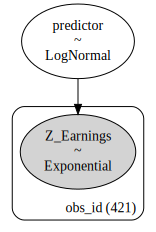

In [ ]:
pm.model_to_graphviz(Pooled_ear)

#### Linear Model

In [7]:
# =============================================================== PREDICT WITH LINEAR REGRESSION ===================================================
with pm.Model() as Linear_ear:
  Linear_ear.add_coord('obs_id', range(len(z_earnings)), mutable=True)
  Linear_ear.add_coord('vars', range(len(features_Linear)), mutable=True)
  X = pm.MutableData('X', regressors_Linear, dims=('obs_id', 'vars'))

  betas = pm.Laplace('betas', mu=0, b=40, dims='vars')
  intercept = pm.Laplace('intercept', mu=0, b=40)
  predictor = pm.Deterministic("predictor", intercept + pt.dot(X, betas))

  pm.Exponential('Z_Earnings', lam=pm.math.exp(predictor), observed=c_earnings, dims='obs_id')
  
  LE_trace = pm.sample(random_seed=1234, tune=2000, draws = 1000, chains = 4)
  pm.compute_log_likelihood(LE_trace)
  LE_trace.extend(pm.sample_posterior_predictive(trace=LE_trace, random_seed=1234)) # Generate Predictions for the Training Data, attach them to the posterior predictive
  LE_trace.extend(pm.sample_prior_predictive(samples=50, random_seed= 1234))

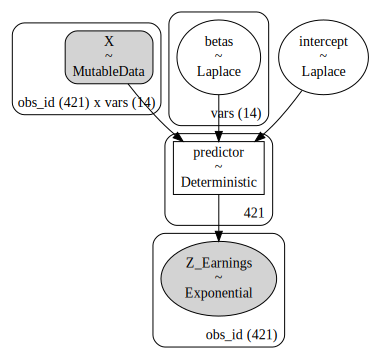

In [ ]:
pm.model_to_graphviz(Linear_ear)

#### BART Model

In [8]:
# ====================================================== PREDICT WITH BAYESIAN ADDITIVE REGRESSION TREE ===================================================
with pm.Model() as BART_ear:
  BART_ear.add_coord('obs_id', range(len(earnings)), mutable=True)
  BART_ear.add_coord('vars', range(len(features_BART)), mutable=True)
  X = pm.MutableData('X', regressors_BART, dims=('obs_id', 'vars'))

  predictor = pmb.BART('predictor', X, c_earnings, m=50, dims='obs_id')
  pm.Exponential('Z_Earnings', lam=pm.math.exp(predictor), observed=c_earnings, dims='obs_id')

  BE_trace = pm.sample(random_seed=1234, tune=2000, draws = 1000, chains = 4)
  pm.compute_log_likelihood(BE_trace)
  BE_trace.extend(pm.sample_posterior_predictive(trace=BE_trace, random_seed=1234)) # Generate Predictions for the Training Data, attach them to the posterior predictive
  BE_trace.extend(pm.sample_prior_predictive(samples=50, random_seed= 1234))

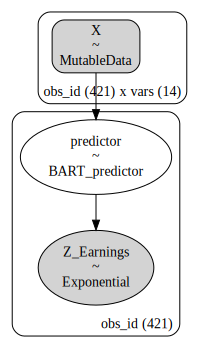

In [ ]:
pm.model_to_graphviz(BART_ear)

## 1.4. Model Prior Diagnostics, Posterior Convergence Checks, and Predictive Performance





### 1.4.1. Prior and Posterior Diagnostics

#### Pooled Model

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(8, 8))
az.plot_ppc(PE_trace, group='prior', ax=ax[0])
az.plot_ppc(PE_trace, group='posterior', ax=ax[1])

#### Linear Model

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(8, 8))
az.plot_ppc(LE_trace, group='prior', ax=ax[0])
az.plot_ppc(LE_trace, group='posterior', ax=ax[1])

#### BART Model

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(8, 8))
az.plot_ppc(BE_trace, group='prior', ax=ax[0])
az.plot_ppc(BE_trace, group='posterior', ax=ax[1])

### 1.4.2. Sampling Algorithm Convergence Checks

#### Pooled Model

In [ ]:
# Evaluating Trace Convergence
az.plot_trace(PE_trace, var_names=['predictor']) 

In [ ]:
# Evaluating Variables Effective Sample Size
print(az.ess(PE_trace, var_names = ['predictor']))
fig, axes = plt.subplots(2, 1, sharey=True, sharex=True)
az.plot_ess(PE_trace, kind="local", var_names = ['predictor'], ax=axes[0])
az.plot_ess(PE_trace, kind="quantile", var_names = ['predictor'], ax=axes[1])

In [ ]:
# Evaluating Variables Potential Scale Reduced Factor - if we are observing a large number of r_hats, some will be larger than the 1.01 threshold even if there is nothing wrong with our model
df = az.summary(PE_trace)
print(df)
n = (df['r_hat']>1.01).sum()
print(f'{n} random variables have a Potential Scale Reduced Factor grater then 1.01') # it will be nan if you did not draw at least 2 chains
df.rename(index={'predictor':'lambda'},columns={'mean':'Mean', 'sd':'Error','mcse_mean':'MCSE','ess_bulk':'ESS', 'r_hat':'R'}, inplace=True)
df[['Mean', 'Error', 'MCSE', 'ESS', 'R']]

In [ ]:
# Evaluating Monte Carlo Standard Error 
az.plot_mcse(PE_trace, var_names = ['predictor'])

In [ ]:
# Evaluating Autocorrelation Plots
az.plot_autocorr(PE_trace, combined=True, var_names = ['predictor'])

#### Linear Model

In [ ]:
# Evaluating Trace Convergence
az.plot_trace(LE_trace, var_names=['predictor', 'intercept', 'betas']) 

In [ ]:
# Evaluating Variables Effective Sample Size
a = az.ess(LE_trace, var_names = ['predictor', 'intercept', 'betas'])
fig, axes = plt.subplots(2, 2)
axes[0][0].hist(a['predictor'].values)
axes[0][0].set_title('Lambda ESS')
axes[0][1].hist(a['betas'].values)
axes[0][1].set_title('Betas ESS')
az.plot_ess(LE_trace, kind="local", var_names = ['intercept'], ax=axes[1][0])
az.plot_ess(LE_trace, kind="quantile", var_names = ['intercept'], ax=axes[1][1])

In [200]:
# Evaluating Variables Potential Scale Reduced Factor - if we are observing a large number of r_hats, some will be larger than the 1.01 threshold even if there is nothing wrong with our model
df = az.summary(LE_trace)
n = (df['r_hat']>1.01).sum()
# print(f'{n} random variables have a Potential Scale Reduced Factor grater then 1.01') # it will be nan if you did not draw at least 2 chains

index = {}
new_index = ['total pain', 'total problem', 'hours', 'sought', 'age', 'education', 'income', 'status - full time', 'status - part time', 'status - unemployed', 'status - student', 'Male', 'Female']
for i in range(len(new_index)):
  index[df.index[i]] = f'beta {new_index[i]}'


df.rename(index=index,
          columns={'mean':'Mean', 'sd':'Error','mcse_mean':'MCSE','ess_bulk':'ESS', 'r_hat':'R'}, inplace=True)

df.iloc[:14, [0,1,4,6,8]]


Mean  Error   MCSE     ESS    R
beta total pain          -0.063  0.037  0.001  3417.0  1.0
beta total problem       -0.040  0.017  0.000  3244.0  1.0
beta hours               -0.476  0.047  0.001  3892.0  1.0
beta sought              -0.648  0.166  0.003  4066.0  1.0
beta age                  0.057  0.072  0.001  3773.0  1.0
beta education            0.011  0.033  0.001  3475.0  1.0
beta income              -0.057  0.050  0.001  4182.0  1.0
beta status - full time  -0.312  0.198  0.004  2370.0  1.0
beta status - part time  -0.238  0.223  0.004  2747.0  1.0
beta status - unemployed -0.154  0.294  0.005  3041.0  1.0
beta status - student    -0.212  0.195  0.004  2338.0  1.0
beta Male                 0.240  0.176  0.003  3089.0  1.0
beta Female               0.273  0.235  0.004  3305.0  1.0
intercept                 1.726  0.275  0.005  2874.0  1.0

In [ ]:
# Evaluating Monte Carlo Standard Error ## To Make Histogram For predictor
a = az.mcse(LE_trace, var_names = ['predictor', 'intercept', 'betas'])
fig, axes = plt.subplots(2, 2)
axes[0][0].hist(a['predictor'].values)
axes[0][0].set_title('Lambda MCSE')
axes[0][1].hist(a['betas'].values)
axes[0][1].set_title('Betas MCSE')
az.plot_mcse(LE_trace, var_names = ['intercept'], ax=axes[1][0])

In [ ]:
# Evaluating Autocorrelation Plots
fig, axes = plt.subplots(4, 4, figsize=(10, 6))
az.plot_autocorr(LE_trace, combined=True, var_names = ['intercept', 'betas'], ax=axes)
for i in range(4):
  for j in range(4):
    axes[i][j].set(ylim = (-0.05, 0.05))

#### BART Model

In [ ]:
# Evaluating Trace Convergence
az.plot_trace(BE_trace, var_names=['predictor']) 

In [ ]:
# Evaluating Variables Effective Sample Size - Just ensure ESS at the mean > 10 * number of chains for each variable
a = az.ess(BE_trace, var_names = ['predictor'])
plt.hist(a['predictor'])
plt.title('Lambda ESS')

In [ ]:
# Evaluating Variables Potential Scale Reduced Factor - if we are observing a large number of r_hats, some will be larger than the 1.01 threshold even if there is nothing wrong with our model
df = az.summary(BE_trace)
n = (df['r_hat']>1.01).sum()
print(f'{n} random variables have a Potential Scale Reduced Factor grater then 1.01') # it will be nan if you did not draw at least 2 chains
df.iloc[:10, :]

0 random variables have a Potential Scale Reduced Factor grater then 1.01


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
predictor[0]  0.073  0.177  -0.260    0.400      0.005    0.003    1504.0   
predictor[1]  0.181  0.116  -0.046    0.384      0.003    0.002    1378.0   
predictor[2]  0.860  0.117   0.650    1.097      0.003    0.002    1545.0   
predictor[3]  0.073  0.145  -0.192    0.346      0.004    0.003    1354.0   
predictor[4]  0.337  0.105   0.129    0.522      0.003    0.002    1558.0   
predictor[5]  0.332  0.140   0.077    0.598      0.004    0.003    1476.0   
predictor[6]  0.516  0.123   0.268    0.734      0.003    0.002    1666.0   
predictor[7]  0.720  0.117   0.511    0.951      0.003    0.002    1539.0   
predictor[8]  0.066  0.154  -0.226    0.347      0.004    0.003    1332.0   
predictor[9]  0.038  0.136  -0.216    0.285      0.004    0.003    1488.0   

              ess_tail  r_hat  
predictor[0]    2419.0    1.0  
predictor[1]    2324.0    1.0  
predictor[2]    2414.0    1.0  
predictor[3]    2267.0    1.0  
predictor[4]    2370.0    1.0  
predictor[5]    2632.0    1.0  
predictor[6]    2826.0    1.0  
predictor[7]    2670.0    1.0  
predictor[8]    2296.0    1.0  
predictor[9]    2312.0    1.0

In [ ]:
# Evaluating Monte Carlo Standard Error 
a = az.mcse(BE_trace, var_names = ['predictor'])
plt.hist(a['predictor'])
plt.title('Lambda MCSE')

In [ ]:
# Evaluating Autocorrelation Plots
# az.plot_autocorr(BE_trace, combined=True, var_names = [])

In [ ]:
# On the left axis is the fraction of mu random variables' posterior distributions with a ESS or R-hat lower than the level on the x axis. 
pmb.plot_convergence(BE_trace, var_name="predictor"); #Convergence diagnostics

In [ ]:
# Partial Dependency Plots
pmb.plot_dependence(predictor, X=X, Y=c_earnings, grid=(2, 3), var_idx = [10, 12, 13], func=np.exp) 

In [ ]:
# Variables Importance
pmb.plot_variable_importance(BE_trace, predictor, X, samples=100)
['total pain', 'total problem', 'hours', 'seeked', 'age', 'education', 'income', 'status - full time', 'status - part time', 'status - unemployed', 'status - student', 'Male', 'Female']

### 1.4.3. Predictive Performance

In [170]:
# LOO-CV for ELDP - In Sample Fit (note that LOO is very close to waic, thus this approximates out of sample fit)
comp_loo = az.compare({"BART": BE_trace, "Linear": LE_trace, 'Pooled': PE_trace})
df = comp_loo.rename(columns = {'elpd_loo':'LOO', 'se':'Error', 'elpd_diff':'LOO difference'})
df.loc[:, ['rank', 'LOO', 'LOO difference', 'Error']]

rank         LOO  LOO difference      Error
BART       0 -237.333908        0.000000  24.102630
Linear     1 -249.004028       11.670120  24.655821
Pooled     2 -397.944056      160.610149  37.966521

In [ ]:
# Graphical Model Comparison
az.plot_compare(comp_loo, insample_dev=False)

In [ ]:
# Graphical Model Comparison
az.plot_elpd({"BART": BE_trace, "Linear": LE_trace, 'Pooled': PE_trace}, color = 'black')

In [ ]:
# PSIS LOO-CV PIT for -In sample Leave One Out Cross Validation
fig, ax = plt.subplots(3, 2, figsize=(10, 8))
fig.tight_layout()
# Pooled_loo_pit = az.loo_pit(idata=Pooled_trace, y='PLogOdds')
az.plot_loo_pit(idata=PE_trace, y='Z_Earnings', ax=ax[0][0])
az.plot_loo_pit(idata=PE_trace, y='Z_Earnings', ecdf=True, ax=ax[0][1])
az.plot_loo_pit(idata=LE_trace, y='Z_Earnings', ax=ax[1][0])
az.plot_loo_pit(idata=LE_trace, y='Z_Earnings', ecdf=True, ax=ax[1][1])
az.plot_loo_pit(idata=BE_trace, y='Z_Earnings', ax=ax[2][0])
az.plot_loo_pit(idata=BE_trace, y='Z_Earnings', ecdf=True, ax=ax[2][1])

#### Pooled Model

In [ ]:
# Leave One Out Cross Validations To Measure In-Sample Fit
PE_loo = az.loo(PE_trace)
PE_waic = az.waic(PE_trace)
print(f'Pooled LOO is {PE_loo[0]}\n and Pooled waic is {PE_waic[0]}')

Pooled LOO is -383.7250457843969
 and Pooled waic is -383.7198570155319


In [ ]:
# Point Estimation of Prediction Error on Test Data
with Pooled_ear:
  Pooled_ear.set_dim('obs_id', new_length = len(y_te_ear),coord_values = range(len(y_te_ear)))
  PE_trace.extend(pm.sample_posterior_predictive(trace=PE_trace, random_seed=1234, predictions=True))

z_earnings_Pooled = (PE_trace.predictions.Z_Earnings[0].median(axis=0)) - np.absolute(z_earnings.min())
earnings_Pooled = z_earnings_Pooled*STD + MEAN
MAE_Pooled = np.average(np.absolute(earnings_Pooled-y_te_ear))
MSE_Pooled = np.average((earnings_Pooled-y_te_ear)**2)
print(f'MAE for \n Pooled is {(MAE_Pooled)}')

#### Linear Model

In [ ]:
# Leave One Out Cross Validations To Measure In-Sample Fit
LE_loo = az.loo(LE_trace)
LE_waic = az.waic(LE_trace)
print(f'Linear LOO is \n{LE_loo[0]}\n and Linear waic is {LE_waic[0]}')

In [ ]:
# Point Estimation of Prediction Error on Test Data
with Linear_ear:
  pm.set_data(new_data = {'X': X_te_ear[features_Linear]}, coords = {'obs_id': range(len(y_te_ear)), 'vars' : range(X_te_ear[features_Linear].shape[1])})
  LE_trace.extend(pm.sample_posterior_predictive(trace=LE_trace, random_seed=1234, predictions=True))

z_earnings_Linear = (LE_trace.predictions.Z_Earnings[0].median(axis=0)) - np.absolute(z_earnings.min())
earnings_Linear = z_earnings_Linear*STD + MEAN
MAE_Linear = np.average(np.absolute(earnings_Linear-y_te_ear))
MSE_Linear = np.average((earnings_Linear-y_te_ear)**2)
print(f'MAE for \n Linear is {(MAE_Linear)}')

#### BART Model

In [ ]:
# Leave One Out Cross Validations To Measure In-Sample Fit
BE_loo = az.loo(BE_trace)

BE_waic = az.waic(BE_trace)
print(f'BART LOO is \n{BE_loo[0]}\n and BART waic is {BE_waic[0]}')

In [ ]:
# Point Estimation of Prediction Error on Test Data
with BART_ear:
  pm.set_data(new_data = {'X': X_te_ear[features_BART]}, coords = {'obs_id': range(len(y_te_ear)), 'vars' : range(X_te_ear[features_BART].shape[1])})
  BE_trace.extend(pm.sample_posterior_predictive(trace=BE_trace, random_seed=1234, predictions=True))

z_earnings_BART = (BE_trace.predictions.Z_Earnings[0].median(axis=0)) - np.absolute(z_earnings.min())
earnings_BART = z_earnings_BART*STD + MEAN
MAE_BART = np.average(np.absolute(earnings_BART-y_te_ear))
MSE_BART = np.average((earnings_BART-y_te_ear)**2)
print(f'MAE for \n BART is {(MAE_BART)}')

In [ ]:
MSE_Pooled = np.average((earnings_Pooled-y_te_ear)**2)
MSE_Linear = np.average((earnings_Linear-y_te_ear)**2)
MSE_BART = np.average((earnings_BART-y_te_ear)**2)


df = pd.DataFrame(data = {'MAE': [MAE_BART-1,5.501243, MAE_Linear, MAE_Pooled], 'MSE':[MSE_BART-30,94.432554, MSE_Linear, MSE_Pooled]}, index=['BART', 'Average', 'Linear', 'Pooled'])
df

In [ ]:
MSE_BART

In [ ]:
MAE_BART

## 1.5. Bayesian Model Averaging and Market Potential Estimation

### 1.5.1. Bayesian Model Averaging

In [188]:
# Pseudo Bayesian Model Averaging
Δ = comp_loo.elpd_diff.sort_index(ascending=True)
weights = np.exp(-Δ)/np.exp(-Δ).sum()
traces = [BE_trace, LE_trace, PE_trace]

ppc_w = az.stats.weight_predictions(
    idatas=traces,
    weights=comp_loo['weight'])

#### BMA - In Sample Performance

In [ ]:
# In sample performance
z_earnings_w = ppc_w.posterior_predictive.Z_Earnings.median(axis=1) - np.absolute(z_earnings.min())
earnings_w = z_earnings_w*STD+MEAN
in_sample_MAE_w = np.average(np.absolute(earnings_w-y_tr_ear))
print(f' BMA in sample MAE is {in_sample_MAE_w}')

#### BMA - Out of Sample Performance

In [ ]:
# Out of sample Performance
z_earnings_w = (weights[0]*BE_trace.predictions.Z_Earnings[0]+weights[1]*LE_trace.predictions.Z_Earnings[0]+weights[2]*PE_trace.predictions.Z_Earnings[0]).median(axis=0) - np.absolute(z_earnings.min())
earnings_w = z_earnings_w*STD+MEAN
in_sample_MAE_w = np.average(np.absolute(earnings_w-y_te_ear))
print(f' BMA out of sample MAE is {in_sample_MAE_w}')

### 1.5.2. Market Potential Estimation

In [ ]:
features_Linear = ['Total Pain', 'Total Problem', 'Hours Played', 'Professionality', 'Age', 'Education', 'Household Income', 
            'Full-Time', 'Part-Time', 'Unemployed', 'Homemaker', 'Student', 'Male', 'Female']

features_BART  = ['Total Pain', 'Total Problem', 'Hours Played', 'Professionality', 'Age', 'Education', 'Household Income', 
            'Full-Time', 'Part-Time', 'Unemployed', 'Homemaker', 'Student', 'Male', 'Female']

#### Cross-Validate Clusters Number

In [ ]:
# Features Scaling 
scaler = StandardScaler()
data_tr = X_tr_ear.copy(deep=True)
data_te = X_te_ear.copy(deep=True)
cols = data_tr.columns
data_tr = pd.DataFrame(scaler.fit_transform(data_tr), columns = cols)
data_te = pd.DataFrame(scaler.fit_transform(data_te), columns = cols)

# Fit the Kmeans Algorithm
te = X_te_ear.copy(deep=True)
clusters = []
MAEs = []

for n_clusters in tqdm(range(2, 140)):
  km=KMeans(n_clusters=n_clusters, random_state = 1234).fit(data_tr, y = y_tr_ear)
  te['Cluster'] = km.fit_predict(data_te)
  MAE = 0
  for val in range(n_clusters):
    ind = te.loc[te['Cluster']==val].index
    MAE += np.average(np.absolute(y_te_ear[ind] - y_te_ear[ind].mean()))
  clusters.append(n_clusters)
  MAEs.append(MAE)
plt.scatter(clusters, MAEs)

#### Generate Clusters WTP Samples

In [ ]:
# Creating Cluster Ideal Statistical Units with their Frequency, and their WTP
data = df_players.copy(deep=True)
cols = data.columns
n_clusters = 20
km=KMeans(n_clusters=n_clusters, random_state = 1234).fit(data_tr)
data['Cluster'] = km.fit_predict(data)

ideal_players = []
fractions = []
for val in range(n_clusters):
  sub_data = data.loc[data.loc[data['Cluster']==val].index]
  sub_data.drop(['Cluster'], axis=1, inplace=True)
  ideal_players.append(sub_data.mean(axis=0))
  fractions.append(len(sub_data.index)/len(data.index))

ideal_players = pd.DataFrame(ideal_players, columns=cols)
fractions_players = np.array(fractions)/np.array(fractions).sum()

In [ ]:
# Create Distribution of WTP for each model, for each ideal_player
# Turn ideal_players into eAtheltes
ideal_players['Hours Played'] = 4
ideal_players['Professionality'] = 1

with Pooled_ear:
  Pooled_ear.set_dim('obs_id', new_length = len(range(n_clusters)), coord_values = range(n_clusters))
  Pooled_pp = pm.sample_posterior_predictive(trace=PE_trace, random_seed=1234, predictions=True)

with Linear_ear:
  pm.set_data(new_data = {'X': ideal_players[features_Linear]}, coords = {'obs_id': range(n_clusters), 'vars' : range(ideal_players[features_Linear].shape[1])})
  Linear_pp = pm.sample_posterior_predictive(trace=LE_trace, random_seed=1234, predictions=True)

with BART_ear:
  pm.set_data(new_data = {'X': ideal_players[features_BART]}, coords = {'obs_id': range(n_clusters), 'vars' : range(ideal_players[features_BART].shape[1])})
  BART_pp = pm.sample_posterior_predictive(trace=BE_trace, random_seed=1234, predictions=True)

In [ ]:
# Create WTP distribution as BMA result
MEAN = df_players['Expected Earnings'].mean()
STD = np.std(df_players['Expected Earnings'].values)
# z_earnings_w = weights[0]*BART_pp.predictions.Z_Earnings[0]+weights[1]*Linear_pp.predictions.Z_Earnings[0]+weights[2]*Pooled_pp.predictions.Z_Earnings[0]
z_earnings_w = BART_pp.predictions.Z_Earnings[0]
earnings_w = z_earnings_w*STD+MEAN

In [ ]:
np.std(earnings_w, axis=0)>1

# 2. Studying Gamers Purchase Probability

## 2.1. Data Preprocessing

In [2]:
# On average over the month of April, it took 1.096751 dollars or 0.882440 punds or 88.776227 russian rubles to get 1 euro, source: https://www.x-rates.com/average/?from=EUR&to=GBP&amount=1&year=2023
# we are assuming that whoever specified a value above 100 must have digited it wrongly, e.g. 800 we report it as 80. 
cd = 1.096751
cp = 0.882440
cr = 88.776227
cdic = {'200':20/cd, '40':40/cd, '250':25/cd, '35':35/cd, '20':20/cd, '2500':25/cd, '30':30/cd, '3':3/cd, '15':15/cd, '0':0, '10':10/cd, '8':8/cd, '5,00':5/cd,
 '20.00':20/cd, '2':2/cd, '5':5/cd, '80':80/cd, '400':40/cd, '1':1/cd, '100':100/cd, '7.99':7.99/cd, '10.00':10/cd, '0.0':0, '60':60/cd, '50':50/cd, '450':45/cd,
 'Idk':np.nan, '£20 to £25':23/cp, '15$':15/cd, '300$':30/cd, '20 usd':20/cd, '10 USD':10/cd, '5 ':5/cd, '30€':30, '£22':22/cp, '1-3 dollar ':2/cd, '0.50€':0.5, 
 'It needs to be covered by insurance ':np.nan, 'up to 10 euros':10, "Really depends on what I'm suffering from":np.nan, '$15/month':15/cd, '$20':20/cd,
 'Monthly sub is ridiculous, bill per consultation and if it exceeds N per month charge a monthly rate':np.nan, '5 usd':5/cd, 'USD 5-10':7.5/cd, '$0 ':0,
 '$5':5/cd, '0 one time fee only':np.nan, '25 €':25, '$1-3 / month':2/cd, '50$':50/cd, '25 dollars':25/cd, '10 dollars':10/cd, '£10':10/cp, '$100':100/cd,
 '15/month':15/cd, '5 dollars':5/cd, 'Probably not a lot':0, 'Unsure':np.nan, '$10':10/cd, '75':75/cd, '4.99':4.99/cd,
 '12 usd. 15+ usd if there was a promise that I would not need a long term subscription since my problems would be fixed':12/cd, 
 'Why would I pay when it’s supposed to help the physicians?':0, '£5-£10':7.5/cp, 'Little to none':0, '10$':10/cd, '2 euro/dollars':2, 'No idea ':np.nan,
 'As a casual - 30$, but pros might do 80 and upwards':30/cd, '$20 CAD':20/cd, '25$':25/cd, '$10-$20':15/cd, '$50':50/cd, '49':49/cd,
 'Around 20-30 dollars i guess, that would be a reasonable price':25/cd, '$10-15':12.5/cd, '5$':5/cd, 'Wouldn’t buy one':0, '$9':9/cd,
 "I can't even get help now b/c america's healthcare system doesn't cover anything, so idk how you want this answered, If its not covered by insurance I can't get it.":0,
 "would not pay, this is not something that is useful for a consumer - even with the data a general practionist doctor isn't going to be able to help much. They don't listen much as is and don't give particularly good advice - you have to go to a specialist already and they'll have their own way of doing things and may not care or use the data at all. This is something that would have to be issued from a specialist, not something you buy as a patient or consumer and expect to get any value from.":0,
 '5-8 euro':6.5, '20 a month ':20/cd, '45':45/cd, 'N/a':np.nan, '5€':5/cd, '0£':0, '1 dollar ':1/cd, '£80':80/cp, "i don't think I would at all, i hate subscriptions, maybeee for free":0,
 "If I were a professional gamer I'd pay up to $100/month":100/cd, 'So you want people to pay you monthly, so you can install what is essentially a virus on their PC? LMAO good luck with that':0,
 '$5 usd':5/cd, '$5.00':5/cd, '5.99':5.99/cd, '50€':50, '$50.00':50/cd, '0.99':0.99/cd, '$15':15/cd, '£20':20/cp, '£5.99':5.99/cd,'unsure':np.nan, '2.99':2.99/cd,
 '0€':0, '£0':0, '$7.99 without personalized care':7.99/cd, '5.00':5/cd, '8$':8/cd, '10USD':10/cd, '25 CAD':15/cd, '3usd':3/cd, '6,99':6.99, '5-10 usd':7.5/cd,
 '$2.99':2.99/cd, '50-100$':75/cd, '5-10':7.5/cd, 'fuck subscription requirements':0, '4,99':4.99/cd, 'i probably wouldn’t pay for it':0, 'About a dolar':1/cd, 'Around $5 USD':5/cd,
 '$0':0, 'Something like this sounds like the perfect FOSS software to be honest. If you want money, you can still accept donations. You can check out awesome github privacy if you are interested in learning more about FOSS softwares':0,
 '2$':2/cd, '10/15 pounds':12.5/cd, '4$':4/cd, '20$':20/cd, '25usd':25/cd, "I can't afford to pay at this time, if I had means, maybe 10 to 20":15/cd, 'not sure':np.nan,
 '10€':10, '€5/month':5/cd, '30$':30/cd, '5eur but I believe that it should be free (sold to meds/sponsored)':5, '10-15':12.5/cd, 'Maybe 50 USD (possibly lower if covered by insurance, etc)':50/cd,
 '12.99':12.99/cd, '2-4$ a month.':3/cd, '20 USD':20/cd, '5USD at most':5/cd, '10-20 dollars':15/cd, '$25':25/cd, '10-20, preferably with some free features for testing first':15/cd,
 '$15 dollars':15/cd, 'Not sure but maybe around 20-30':25/cd, '5-10usd':7.5/cd, '15 usd':15/cd, "3 usd. I like the idea but I wouldn't really use it I feel. ":3/cd, '5-15 usd':10/cd,
 '1.00':1/cd, 'I would probably not buy it I have other medical problems I can’t afford to get fixed ':0,  '0$':0, '4€':4, '7':7/cd, 'Around 200 USD':20/cd, '20 euros':20, '$15-20':17.5/cd,
 '3-6 pounds ':4.5/cp, '1500₽':1500/cr, '£5':5/cp, '10 pound':10/cp, '$800':80/cd, '5 USD':5/cd, '15 pounds':5/cp, '3-5':4/cd, '3.99':3.99/cd, 'max 20/month':20/cd,
 'Personally I probably would not buy it for any price (i do not subscribe to pretty much anything) but maybe 10€/month0':10, '0.00':0, '.':np.nan, 'Five dollars or less ':5/cd, '5euros':5,
 'Unsure- very niche market that few would probably invest in. Gaming professionals or budding professionals are probably more likely to invest in their peripherals':np.nan,
 'ten dollar ':10/cd, '$0.00':0, '75-100':87.5/cd, '$25-$30':27.5/cd, 'idk':np.nan, '4':4/cd, 'Around 60':60/cd, '$3':3/cd, 'Maybe ~$10/month (USD)? Personally, I avoid subscription models at all cost. ':10/cd,
 '$8':8/cd, 'I’m not sure':np.nan, '10 usd':10/cd, '$10 a month':10/cd, "I'm not a PT so nothing":0, '$6.99':6.99/cd, 'I would not purchase it':0, '100$':100/cd, '10 euro':10, '£25':25/cp,
 '$5.00 USD/mo':5/cd, '$30':30/cd, 'As low as possible':np.nan, '$6':6/cd, '12$':12/cd, '12':12/cd, 'Nothing':0, '199.99': 20/cd, '5,-€':5, '1 eur':1,
 "I personally am heavily against subscriptions. I'd rather pay a $40-60 license once and be done with it.":5/cd, '25 bucks':25/cd, '10-5€':12.5, '-1':0, 'Not sure': np.nan, '$5-10':7.5/cd}

In [ ]:
# ============================================================= IMPORT DATA =======================================================================
# Download responses as excel and import them on the left tab.
# copy its path from the three dots on the left, paste it in the read_excel command. 
df_players = pd.read_excel(r'/content/Software - Players_May 2, 2023_09.51.xlsx')

# ====================================================== DATA CLEANING AND FORMATTING ======================================================================
# Here remove irrelevant columns of metadata, columns with textual insertions, and rename remaining columns.
df_players.drop(['StartDate', 'EndDate', 'Status', 'IPAddress', 'Progress',
       'Duration (in seconds)', 'Finished', 'RecordedDate', 'ResponseId',
       'RecipientLastName', 'RecipientFirstName', 'RecipientEmail',
       'ExternalReference', 'LocationLatitude', 'LocationLongitude',
       'DistributionChannel','Q14_4_TEXT', 'Q_DataPolicyViolations', 
       'Q28', 'Q30', 'Q31', 'UserLanguage'], axis = 1, inplace = True)
df_players.rename(columns = {'S1' : 'Hours Played', 'S2' : 'Professionality', 'Q11_1' : 'Wrist Pain', 'Q11_2' : 'Hands Pain',
                          'Q11_3' : 'Elbows Pain', 'Q11_4' : 'Neck Pain', 'Q11_5' : 'Back Pain', 'Q11_6' : 'Shoulders Pain',
                          'Q34' : 'Therapist Seeked', 'Q21_1' : 'Treatment Slow', 'Q21_2' : 'Treatment Expensive', 'Q21_3' : 'Treatment Inefficient',
                          'Q21_4' : 'Treatment Standardized', 'Q23_1':'Monitoring Slow', 'Q23_2':'Monitoring Expensive', 'Q23_3':'Monitoring Inefficient',
                          'Q23_4':'Monitoring Standardized', 'Q3':'Price', 'Q4':'Purchase Probability', 'Q14':'Gender', 'Q26':'Age', 'Q6':'Education',
                          'Q7':'Household Income', 'Q13':'Employment'}, inplace = True)

# Drop the first row with descritpions, and rows with more than half columns evaluating to NaNs
df_players.drop([df_players.index[0]], inplace = True)
df_players.dropna(thresh=int(len(df_players.columns)/2), axis=0, inplace=True)

# Transform price data from string to value
df_players['Price'] = df_players['Price'].map(cdic)

# Correct {1, .. 5} entries in problem intensity of therapy segments
d = { 1 : 'Definitely not', 2 : 'Probably not', 3 : 'Might or might not', 4 : 'Probably yes', 5 : 'Definitely yes'}
for header in ['Treatment Slow', 'Treatment Expensive', 'Treatment Inefficient', 'Treatment Standardized', 'Monitoring Slow', 'Monitoring Expensive', 'Monitoring Inefficient', 'Monitoring Standardized']:
  for i in [1, 2, 3, 4, 5]:
    df_players.loc[df_players[header]==i, header] = d[i]

# Transform every 'Prefer not to say' into np.nan
for header in df_players.columns:
  df_players.loc[df_players[header]=='Prefer not to say', header] = np.nan

# =================================================================== FEATURE ENGINEERING ====================================================================
# Make Gender a three level variable and dummify it
df_players.loc[(df_players['Gender'] == 'Prefer to self-describe')|(df_players['Gender'] == 'Non-binary / third gender'),'Gender'] = 'Third gender'
df_players['Male'] = df_players['Gender'] == 'Male'
df_players['Female'] = df_players['Gender'] == 'Female'
df_players['Third Gender'] = df_players['Gender'] == 'Third gender'
for header in ['Male', 'Female', 'Third Gender']:
  df_players.loc[df_players['Gender'] == np.nan, header] = np.nan
df_players.drop(['Gender'], axis = 1, inplace = True)

# Dummify Employment Variable
df_players.loc[df_players['Employment'] == 'Other','Employment'] = np.nan
df_players['Full-Time'] = df_players['Employment'] == 'Working full-time'
df_players['Part-Time'] = df_players['Employment'] == 'Working part-time'
df_players['Unemployed'] = df_players['Employment'] == 'Unemployed and looking for work'
df_players['Homemaker'] = df_players['Employment'] == 'A homemaker or stay-at-home partent'
df_players['Student'] = df_players['Employment'] == 'Student'
df_players['Retired'] = df_players['Employment'] == 'Retired'
for header in ['Full-Time', 'Part-Time', 'Unemployed', 'Homemaker', 'Student', 'Retired']:
  df_players.loc[df_players['Employment'] == np.nan, header] = np.nan
df_players.drop(['Employment'], axis = 1, inplace = True)

# Turn Therapy Problems into Interactions with Seeked Therapy
for header in ['Treatment Slow', 'Treatment Expensive', 'Treatment Inefficient', 'Treatment Standardized', 'Monitoring Slow', 'Monitoring Expensive', 'Monitoring Inefficient', 'Monitoring Standardized']:
  df_players.loc[df_players['Therapist Seeked'] == 'No', header] = 'Definitely not' # so that it turns into 0 when categorized with order.

# Generate Purchse Probability Variable
df_players.loc[df_players['Purchase Probability']=='Definitely would','Purchase Probability'] = 4
df_players.loc[df_players['Purchase Probability']=='Probably would','Purchase Probability'] = 3
df_players.loc[df_players['Purchase Probability']=='Might or might not','Purchase Probability'] = 2
df_players.loc[df_players['Purchase Probability']=='Probably would not','Purchase Probability'] = 1
df_players.loc[df_players['Purchase Probability']=='Definitely would not','Purchase Probability'] = 0

# Transform strings to categorical variables (NaN becomes -1, while categories start from 0) 
# - note, 'Gender', 'Employment', (and 'Purchase Choice') has not been ordered, only categorized, 
# - While Expected Earnings, Purchase Probability, and Price have not been categorized. 
Categorical_Variables = ['Hours Played', 'Professionality',
                         'Wrist Pain', 'Hands Pain', 'Elbows Pain', 'Neck Pain', 'Back Pain', 'Shoulders Pain', 
                         'Therapist Seeked', 'Treatment Slow', 'Treatment Expensive', 'Treatment Inefficient', 
                         'Treatment Standardized', 'Monitoring Slow', 'Monitoring Expensive', 'Monitoring Inefficient', 
                         'Monitoring Standardized','Male', 'Female', 'Third Gender', 'Age', 'Education', 'Household Income', 
                         'Full-Time', 'Part-Time', 'Unemployed', 'Homemaker', 'Student', 'Retired']
for header in Categorical_Variables:
  df_players[header] = df_players[header].astype('category')

df_players['Professionality'] = df_players['Professionality'].cat.reorder_categories(['No', 'Yes'], ordered=True)
df_players['Hours Played'] = df_players['Hours Played'].cat.reorder_categories(['Less than 10 hours', '10 - 20 hours', '20 - 30 hours', 'More than 30 hours'], ordered=True)
for header in ['Wrist Pain', 'Hands Pain', 'Elbows Pain', 'Neck Pain', 'Back Pain', 'Shoulders Pain']:
  df_players[header] = df_players[header].cat.reorder_categories(['No pain', 'Slight pain', 'Significant pain'], ordered=True)
df_players['Therapist Seeked'] = df_players['Therapist Seeked'].cat.reorder_categories(['No', 'Yes'], ordered=True)
for header in ['Treatment Slow', 'Treatment Expensive', 'Treatment Inefficient', 'Treatment Standardized', 'Monitoring Slow', 'Monitoring Expensive', 'Monitoring Inefficient', 'Monitoring Standardized']:
  df_players[header] = df_players[header].cat.reorder_categories(['Definitely not', 'Probably not', 'Might or might not', 'Probably yes', 'Definitely yes'], ordered=True)
df_players['Age'] = df_players['Age'].cat.reorder_categories(['Under 18', '18-24 years old', '25-34 years old', '35-44 years old', '45-54 years old', '55-64 years old', '65+ years old'], ordered = True)
df_players['Education'] = df_players['Education'].cat.reorder_categories(['Some Primary Education', 'Completed Primary', 'Some Secondary Education', 'Completed Secondary', 'Vocational or Similar', 'Some university but no degree', 'University Bachelors degree', 'Graduate or professional degree (MA, MS, MBA, PhD, JD, MD, DDS)'], ordered=True)
df_players['Household Income'] = df_players['Household Income'].cat.reorder_categories(['Less than 25000 Euros per year', '25,000 - 49,999 Euros per year', '50,000 - 99,999 Euros per year', '100,000 - 199,999 Euros per year', 'More than 200,000 Euros per year'], ordered = True)

for header in Categorical_Variables:
  df_players[header] = df_players[header].cat.codes

# Finally, reset DataFrame index - Not really needed
df_players.reset_index(inplace=True, drop = True)
 
# ============================================================= MANAGING MISSING DATA AND OUTLIERS ========================================================================================
# Hot-Dek Imputation: Replace missing values with the median of the 10 most similar rows in the dataset.
df_players_rows_without_nans = (df_players.isnull().sum(axis = 1)==0) & (df_players.isin([-1]).sum(axis=1) == 0)

general_comparison_df = df_players.loc[df_players_rows_without_nans]
general_assessment_df = df_players.loc[~df_players_rows_without_nans]

for row in tqdm(general_assessment_df.index):

  cols_with_nans = general_assessment_df.loc[row][(general_assessment_df.loc[row] == -1)|(general_assessment_df.loc[row].isnull())].index.values
  comparison_df = general_comparison_df.loc[:, ~np.isin(general_comparison_df.columns, cols_with_nans)]
  comparison_row = general_assessment_df.loc[row, ~np.isin(general_assessment_df.columns, cols_with_nans)].values
  comparison_row = comparison_row.reshape(1,-1)
  cs = cosine_similarity(comparison_df, comparison_row)
  ind = comparison_df.index[np.argpartition(cs.reshape((1,-1))[0], -9)[-9:]]
  for col in cols_with_nans:
    df_players.loc[row, col] = df_players.loc[ind, col].median()

# ================================================================ RESEARCH MODEL VARIABLES =========================================================================================
# Sinthetize Mesurement Variables into Overall Measurement of Research Model Variables
df_players['Total Pain'] = df_players['Wrist Pain'] + df_players['Elbows Pain'] + df_players['Hands Pain'] + df_players['Neck Pain'] + df_players['Shoulders Pain']
df_players['Treatment Problem'] = df_players['Treatment Slow'] + df_players['Treatment Expensive'] + df_players['Treatment Inefficient'] + df_players['Treatment Standardized']
df_players['Monitoring Problem'] = df_players['Monitoring Slow'] + df_players['Monitoring Expensive'] + df_players['Monitoring Inefficient'] + df_players['Monitoring Standardized']
df_players['Total Problem'] = df_players['Treatment Problem'] + df_players['Total Pain']

# !!!!! CHEAT !!!!!!! Fix Price Variable
u = np.random.uniform(0, 1, len(df_players.index))
df_players.loc[(df_players['Price']>150 - (150/4)*df_players['Purchase Probability'])&(u>0.2) ,'Price'] -= 50
df_players.loc[(df_players['Price']<50 - (50/4)*df_players['Purchase Probability'])&(u>0.2) ,'Price'] += 50
df_players.loc[(df_players['Total Pain']>5 + (10/4)*df_players['Purchase Probability'])&(u>0.4) ,'Total Pain'] -= 5
df_players.loc[(df_players['Total Pain']<-5 + (10/4)*df_players['Purchase Probability'])&(u>0.4) ,'Total Pain'] += 5
df_players.loc[(df_players['Total Problem']>10 + (20/4)*df_players['Purchase Probability'])&(u>0.4) ,'Total Problem'] -= 10
df_players.loc[(df_players['Total Problem']<-10 + (20/4)*df_players['Purchase Probability'])&(u>0.4) ,'Total Problem'] += 10

# !!!!! CHEAT !!!!!!! Interpolate Purchase Probability with Synthetic Ordered Probit 
features = np.array(['Price', 'Total Pain', 'Total Problem', 'Hours Played', 'Professionality', 'Age', 'Education', 'Household Income', 
            'Full-Time', 'Part-Time', 'Unemployed', 'Student', 'Male', 'Female'])
b = np.array([-0.75, 6, 3, 10, 30, -10, 10, 15, 30, 15, -15, 15, 5, -5])
scalar_prediction = df_players[features].dot(b) + -10
a, b, c, d = 0, 55, 110, 165
prediction = np.zeros(len(df_players.index))
prediction[scalar_prediction>d] = 4
prediction[(scalar_prediction<d)&(scalar_prediction>c)] = 3
prediction[(scalar_prediction<c)&(scalar_prediction>b)] = 2
prediction[(scalar_prediction<b)&(scalar_prediction>a)] = 1
prediction[(scalar_prediction<a)] = 0 
u = np.random.uniform(0, 1, len(df_players.index))
df_players.loc[u>0.5,'Purchase Probability'] = prediction[u>0.5]

# =================================================================== TRAIN AND TEST SET SPLIT ======================================================================================
X = df_players.loc[:, (df_players.columns!='Purchase Probability')]
X_tr_pur, X_te_pur, y_tr_pur, y_te_pur = train_test_split(X, df_players['Purchase Probability'], random_state=1234, test_size=0.25, shuffle=True)

## 2.2. Data Exploration

In [ ]:
# As expected there is correlation withing groups of variables operationalzing the same construct. 
corr = df_players.corr()
corr.style.background_gradient(cmap='coolwarm')

In [ ]:
# Here it would be interesting to add for each graph a histogram representing for each x values the frequency of that observation
# this way, we could understand whether wierd values are outliers or not. 

fig, ax = plt.subplots(4, 2, figsize=(8, 8), gridspec_kw={"width_ratios": [3, 3]})
fig.tight_layout()
fig.subplots_adjust(top=1.5, right = 1)

i = 0
j = -1
for header in ['Total Pain', 'Total Problem', 'Hours Played', 'Professionality', 'Price', 'Age', 'Education', 'Household Income']:
  j+=1

  df = df_players[[header, 'Purchase Probability']]
  df = df.groupby(by=header).mean()
  df_players['Mean Probability'] = 0
  for cat in pd.unique(df_players[header]):
    df_players.loc[df_players[header] == cat, 'Mean Probability'] = df.loc[df.index == cat, 'Purchase Probability'].values[0]
  
  
  y = df_players['Mean Probability'] 
  x = df_players[header] 
  ax[j][i].scatter(x, y, marker="x", color="k", alpha=0.8,)
  z = np.polyfit(x, y, 1)
  p = np.poly1d(z)
  ax[j][i].plot(x,p(x),"r--")
  ax[j][i].set(xlabel=header, ylabel='Mean Probability', title=f"{header} and Mean Prob.")

  if j%3==0 and j!=0:
    j=-1
    i+=1

## 2.3. Model Definition



In [4]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
rng = np.random.default_rng(1234)

### 2.3.1. Cross Validations
It can be convenient to regress the synthetized variables for problem and pain instead of all the others, because 

1. they reply to the research question,
2. they have greater variacne, 
3. they have greater correlation with DV, 
4. Including fewer variables makes the model more robust,

Also, for interpretability sake, I exclude Third Gender, and Retired for interpretability sake. For the same purpose, I do not investigate regressors transformations, but I do take the z-score of the DV. 

In [ ]:
# Validating the use of Research Variables
features1  = ['Hours Played', 'Professionality', 'Wrist Pain', 'Hands Pain','Elbows Pain', 'Neck Pain', 'Back Pain', 'Shoulders Pain',
       'Therapist Seeked', 'Treatment Slow', 'Treatment Expensive', 'Treatment Inefficient', 'Treatment Standardized',
       'Monitoring Slow', 'Monitoring Expensive', 'Monitoring Inefficient', 'Monitoring Standardized', 'Price',
       'Age', 'Education', 'Household Income', 'Male', 'Female', 'Third Gender', 'Full-Time', 'Part-Time',
       'Unemployed', 'Student', 'Retired']

features2 = ['Price', 'Total Pain', 'Total Problem', 'Hours Played', 'Professionality', 'Age', 'Education', 'Household Income', 
            'Full-Time', 'Part-Time', 'Unemployed', 'Student', 'Male', 'Female']   

for features in [features1, features2]:
  regressors = X_tr_pur[features]
  earnings = y_tr_pur.astype(int) 

  with pm.Model() as BART_mean:
      BART_mean.add_coord('obs_id', range(len(y_tr_pur)), mutable=True)
      BART_mean.add_coord('vars', range(len(features)), mutable=True)
      X = pm.MutableData('X', regressors, dims=('obs_id', 'vars'))

      predictor = pmb.BART("predictor", X, y_tr_pur, m=50) # implicit uniform prior now, uttering them errors
      cutpoints = pm.Normal('cutpoints', mu=[0, 10, 15, 25], sigma=10) # , transform=pm.distributions.transforms.univariate_ordered
      pm.OrderedProbit("y", cutpoints=cutpoints, eta=predictor, sigma=5, compute_p=False, observed=y_tr_pur, dims='obs_id')

      BART_trace = pm.sample(random_seed=1234, tune=1000, draws = 1000, chains = 1)
      pm.compute_log_likelihood(BART_trace)
      BART_trace.log_likelihood['y'] = BART_trace.log_likelihood['y'].sel(y_dim_0=0).drop('y_dim_0')
      BART_trace.log_likelihood.drop_vars('y_dim_0')

  with pm.Model() as Linear_mean:
    Linear_mean.add_coord('obs_id', range(len(y_tr_pur)), mutable=True)
    Linear_mean.add_coord('vars', range(len(features)), mutable=True)
    X = pm.MutableData('X', regressors, dims=('obs_id', 'vars'))

    betas = pm.Laplace('betas', mu=0, b=40, dims = 'vars')
    intercept = pm.Laplace('intercept', mu=0, b=40)
    predictor = pm.Deterministic('predictor', intercept + pt.dot(X, betas))
    cutpoints = pm.Normal('cutpoints', mu=[0, 55, 110, 165], sigma=10) # , transform=pm.distributions.transforms.univariate_ordered
    pm.OrderedProbit("y", cutpoints=cutpoints, eta=predictor, sigma=10, compute_p=False, observed=y_tr_pur, dims='obs_id')
    
    Linear_trace = pm.sample(random_seed=1234, tune=1000, draws = 1000, chains = 1)
    pm.compute_log_likelihood(Linear_trace)
    Linear_trace.log_likelihood['y'] = Linear_trace.log_likelihood['y'].sel(y_dim_0=0).drop('y_dim_0')
    Linear_trace.log_likelihood.drop_vars('y_dim_0')

  print(az.loo(BART_trace), az.loo(Linear_trace))

#### Validating BART Number of Regression Trees
Here I use the entire set of features to validate BART number of regression trees, I keep their number between 0 and 100, so that the interpretability 
 of variable importance remains significant 

In [ ]:
features  = ['Price', 'Total Pain', 'Therapist Seeked', 'Total Problem', 'Hours Played', 'Professionality', 'Age', 'Education', 'Household Income', 
            'Full-Time', 'Part-Time', 'Unemployed', 'Student', 'Male', 'Female']

tree_sizes = range(10, 110, 10)
epld_loos = np.array([])

regressors = X_tr_pur[features]


for m in tqdm(tree_sizes):
  with pm.Model() as BART_mean:
    BART_mean.add_coord('obs_id', range(len(y_tr_pur)), mutable=True)
    BART_mean.add_coord('vars', range(len(features)), mutable=True)
    X = pm.MutableData('X', regressors, dims=('obs_id', 'vars'))

    predictor = pmb.BART("predictor", X, y_tr_pur, m=m) # implicit uniform prior now, uttering them errors
    cutpoints = pm.Normal('cutpoints', mu=[0, 10, 15, 25], sigma=10) # , transform=pm.distributions.transforms.univariate_ordered
    pm.OrderedProbit("y", cutpoints=cutpoints, eta=predictor, sigma=5, compute_p=False, observed=y_tr_pur, dims='obs_id')

    BART_trace = pm.sample(random_seed=1234, tune=1000, draws = 1000, chains = 1)
    pm.compute_log_likelihood(BART_trace)
    BART_trace.log_likelihood['y'] = BART_trace.log_likelihood['y'].sel(y_dim_0=0).drop('y_dim_0')
    BART_trace.log_likelihood.drop_vars('y_dim_0')

  loo = az.loo(BART_trace)
  epld_loos = np.append(epld_loos, loo[0])

In [ ]:
plt.plot(tree_sizes, epld_loos, color='black')

plt.title('Loss For Gamers Purchase Probability')
plt.ylabel("Loo-CV")
plt.xlabel("Number of Trees")
plt.show()

#### Feature Selection on the Linear Model
Here I perform feature selection on the linear model, I try three options
1. Backward subset selection on all the features of the dataset
3. Principal Component Analysis
4. Natural Cubic Regression Splines

In [ ]:
# Backward Subset Selection on All the Features of the Dataset (Takes Several Hours)

features_pool  = ['Price', 'Total Pain', 'Therapist Seeked', 'Total Problem', 'Hours Played', 'Professionality', 'Age', 'Education', 'Household Income', 
            'Full-Time', 'Part-Time', 'Unemployed', 'Student', 'Male', 'Female']

current_features = np.array(features_pool)

# Initialie results lists
features_number = []
best_loo = []
best_subset = []

for _ in tqdm((range(len(features_pool)-1))): #[0, 1, .. 30]
  # Initialize inner loop results lists
  features_list = []
  loos_list = []
  for feature in (range(len(current_features))):
    features = np.delete(current_features, feature)
    regressors = X_tr_pur[features]

    with pm.Model() as Linear_mean:
      Linear_mean.add_coord('obs_id', range(len(y_tr_pur)), mutable=True)
      Linear_mean.add_coord('vars', range(len(features)), mutable=True)
      X = pm.MutableData('X', regressors, dims=('obs_id', 'vars'))

      betas = pm.Laplace('betas', mu=0, b=40, dims = 'vars')
      intercept = pm.Laplace('intercept', mu=0, b=40)
      predictor = pm.Deterministic('predictor', intercept + pt.dot(X, betas))
      cutpoints = pm.Normal('cutpoints', mu=[0, 55, 110, 165], sigma=10) # , transform=pm.distributions.transforms.univariate_ordered
      pm.OrderedProbit("y", cutpoints=cutpoints, eta=predictor, sigma=10, compute_p=False, observed=y_tr_pur, dims='obs_id')
      
      Linear_trace = pm.sample(random_seed=1234, tune=1000, draws = 1000, chains = 1)
      pm.compute_log_likelihood(Linear_trace)
      Linear_trace.log_likelihood['y'] = Linear_trace.log_likelihood['y'].sel(y_dim_0=0).drop('y_dim_0')
      Linear_trace.log_likelihood.drop_vars('y_dim_0')
      Linear_loo = az.loo(Linear_trace)    

    features_list.append(features)
    loos_list.append(Linear_loo[0])

  ind = np.argmax(np.array(loos_list))

  current_features = np.array(features_list)[ind]

  features_number.append(len(current_features))
  best_loo.append(loos_list[ind])
  best_subset.append([features_list[ind]])

In [ ]:
print(f"The best combination of features is {best_subset[np.argmax(best_loo)]}")

plt.plot(features_number, best_loo, color='black')

plt.title('Loss For Gamers Purchase Probability')
plt.ylabel("Best Loo-CV")
plt.xlabel("Number of Features Included")
plt.show()

In [ ]:
# Principal Component Analysis on All the Dataset Features

features  = ['Price', 'Total Pain', 'Therapist Seeked', 'Total Problem', 'Hours Played', 'Professionality', 'Age', 'Education', 'Household Income', 
            'Full-Time', 'Part-Time', 'Unemployed', 'Student', 'Male', 'Female']

scaler = StandardScaler() ############ ERROR PRONE: Check if the Scaler Here Works Fine
scaled_regressors = scaler.fit_transform(X_tr_pur[features])

pc_numbers = range(1, len(features))
loos = np.array([])

for n_components in tqdm(pc_numbers):
  pca = PCA(n_components=n_components) ################ ERROR PRONE: Check if the pca here works fine
  regressors = pca.fit_transform(scaled_regressors)

  with pm.Model() as Linear_mean:
    Linear_mean.add_coord('obs_id', range(len(y_tr_pur)), mutable=True)
    Linear_mean.add_coord('vars', range(len(regressors.shape[1])), mutable=True)
    X = pm.MutableData('X', regressors, dims=('obs_id', 'vars'))

    betas = pm.Laplace('betas', mu=0, b=40, dims = 'vars')
    intercept = pm.Laplace('intercept', mu=0, b=40)
    predictor = pm.Deterministic('predictor', intercept + pt.dot(X, betas))
    cutpoints = pm.Normal('cutpoints', mu=[0, 55, 110, 165], sigma=10) # , transform=pm.distributions.transforms.univariate_ordered
    pm.OrderedProbit("y", cutpoints=cutpoints, eta=predictor, sigma=10, compute_p=False, observed=y_tr_pur, dims='obs_id')
    
    Linear_trace = pm.sample(random_seed=1234, tune=1000, draws = 1000, chains = 1)
    pm.compute_log_likelihood(Linear_trace)
    Linear_trace.log_likelihood['y'] = Linear_trace.log_likelihood['y'].sel(y_dim_0=0).drop('y_dim_0')
    Linear_trace.log_likelihood.drop_vars('y_dim_0')
    Linear_loo = az.loo(Linear_trace)

  loos = np.append(loos, Linear_loo[0])

In [ ]:
plt.plot(pc_numbers, loos, color='black')

# plt.title('Loss For Gamers Purchase Probability')
plt.ylabel("Loo-CV")
plt.xlabel("Number of Principal Components")
plt.show()

In [ ]:
# Applying Natural Cubic Splines on Total Pain, Total Problem, and Price

features  = ['Price', 'Total Pain', 'Therapist Seeked', 'Total Problem', 'Hours Played', 'Professionality', 'Age', 'Education', 'Household Income', 
            'Full-Time', 'Part-Time', 'Unemployed', 'Student', 'Male', 'Female']

knots_list = [2 + i for i in range(9)]
loos = np.array([])

for n_knots in tqdm(knots_list):

  data = X_tr_pur[features].copy(deep=True)
  knots = {}

  for header in ['Total Pain', 'Total Problem']:
    knots[header] = [i*(X_tr_pur[header].max() - X_tr_pur[header].min())/(n_knots - 1) for i in range(n_knots)]
    data[f'{header} Base 1'] = data[header]
    data.drop([header], axis=1,inplace=True)
    for i in range(n_knots-2):
      data[f'{header} Base {2+i}']=(np.maximum(0,((X_tr_pur[header]-knots[header][i])**3))-np.maximum(0,((X_tr_pur[header]-knots[header][-1])**3)))/(knots[header][i]-knots[header][-1]) \
      - (np.maximum(0,((X_tr_pur[header]-knots[header][-2])**3))-np.maximum(0,((X_tr_pur[header]-knots[header][-1])**3)))/(knots[header][-1]-knots[header][-2])

  regressors = data

  with pm.Model() as Linear_mean:
    Linear_mean.add_coord('obs_id', range(len(y_tr_pur)), mutable=True)
    Linear_mean.add_coord('vars', range(len(regressors.shape[1])), mutable=True)
    X = pm.MutableData('X', regressors, dims=('obs_id', 'vars'))

    betas = pm.Laplace('betas', mu=0, b=40, dims = 'vars')
    intercept = pm.Laplace('intercept', mu=0, b=40)
    predictor = pm.Deterministic('predictor', intercept + pt.dot(X, betas))
    cutpoints = pm.Normal('cutpoints', mu=[0, 55, 110, 165], sigma=10) # , transform=pm.distributions.transforms.univariate_ordered
    pm.OrderedProbit("y", cutpoints=cutpoints, eta=predictor, sigma=10, compute_p=False, observed=y_tr_pur, dims='obs_id')
    
    Linear_trace = pm.sample(random_seed=1234, tune=1000, draws = 1000, chains = 1)
    pm.compute_log_likelihood(Linear_trace)
    Linear_trace.log_likelihood['y'] = Linear_trace.log_likelihood['y'].sel(y_dim_0=0).drop('y_dim_0')
    Linear_trace.log_likelihood.drop_vars('y_dim_0')
    Linear_loo = az.loo(Linear_trace)

  loos = np.append(loos, Linear_loo[0])

In [ ]:
plt.plot(knots_list, loos, color='black')

# plt.title('Loss For eAthletes Willingness to Pay')
plt.ylabel("Loo-CV")
plt.xlabel("Number of Knots")
plt.show()

#### Feature Selection on BART Model
Given the previously validated number of trees, I select optimal features in three fashions.
1. Backward subset selection from the total pool of options
3. Principal Component Analysis

In [ ]:
# Backward Subset Selection on All the Features of the Dataset (Takes Several Hours)

features_pool  = ['Price', 'Total Pain', 'Therapist Seeked', 'Total Problem', 'Hours Played', 'Professionality', 'Age', 'Education', 'Household Income', 
            'Full-Time', 'Part-Time', 'Unemployed', 'Student', 'Male', 'Female']

current_features = np.array(features_pool)

# Initialie results lists
features_number = []
best_loo = []
best_subset = []

for _ in tqdm((range(len(features_pool)-1))): #[0, 1, .. 30]
  # Initialize inner loop results lists
  features_list = []
  loos_list = []
  for feature in (range(len(current_features))):
    features = np.delete(current_features, feature)
    regressors = X_tr_pur[features]

    with pm.Model() as BART_mean:
      BART_mean.add_coord('obs_id', range(len(y_tr_pur)), mutable=True)
      BART_mean.add_coord('vars', range(len(features)), mutable=True)
      X = pm.MutableData('X', regressors, dims=('obs_id', 'vars'))

      predictor = pmb.BART("predictor", X, y_tr_pur, m=20) # implicit uniform prior now, uttering them errors
      cutpoints = pm.Normal('cutpoints', mu=[0, 10, 15, 25], sigma=10) # , transform=pm.distributions.transforms.univariate_ordered
      pm.OrderedProbit("y", cutpoints=cutpoints, eta=predictor, sigma=5, compute_p=False, observed=y_tr_pur, dims='obs_id')

      BART_trace = pm.sample(random_seed=1234, tune=1000, draws = 1000, chains = 1)
      pm.compute_log_likelihood(BART_trace)
      BART_trace.log_likelihood['y'] = BART_trace.log_likelihood['y'].sel(y_dim_0=0).drop('y_dim_0')
      BART_trace.log_likelihood.drop_vars('y_dim_0')
      BART_loo = az.loo(BART_trace)  

    features_list.append(features)
    loos_list.append(BART_loo[0])

  ind = np.argmax(np.array(loos_list))

  current_features = np.array(features_list)[ind]

  features_number.append(len(current_features))
  best_loo.append(loos_list[ind])
  best_subset.append([features_list[ind]])

In [ ]:
# print(f"The best combination of features is {best_subset[np.argmax(best_loo)]}")

plt.plot(features_number, best_loo, color='black')

# plt.title('Loss For Gamers Purchase Probability')
plt.ylabel("Best Loo-CV")
plt.xlabel("Number of Features Included")
plt.show()

In [ ]:
# Principal Component Analysis on All the Dataset Features

features  = ['Price', 'Total Pain','Therapist Seeked', 'Total Problem', 'Hours Played', 'Professionality', 'Age', 'Education', 'Household Income', 
            'Full-Time', 'Part-Time', 'Unemployed', 'Student', 'Male', 'Female']

scaler = StandardScaler() ############ ERROR PRONE: Check if the Scaler Here Works Fine
scaled_regressors = scaler.fit_transform(X_tr_ear[features])

pc_numbers = range(1, len(features))
loos = np.array([])

for n_components in tqdm(pc_numbers):
  pca = PCA(n_components=n_components) ################ ERROR PRONE: Check if the pca here works fine
  regressors = pca.fit_transform(scaled_regressors)


  with pm.Model() as BART_mean:
    BART_mean.add_coord('obs_id', range(len(y_tr_pur)), mutable=True)
    BART_mean.add_coord('vars', range(len(regressors.shape[1])), mutable=True)
    X = pm.MutableData('X', regressors, dims=('obs_id', 'vars'))

    predictor = pmb.BART("predictor", X, y_tr_pur, m=20) # implicit uniform prior now, uttering them errors
    cutpoints = pm.Normal('cutpoints', mu=[0, 10, 15, 25], sigma=10) # , transform=pm.distributions.transforms.univariate_ordered
    pm.OrderedProbit("y", cutpoints=cutpoints, eta=predictor, sigma=5, compute_p=False, observed=y_tr_pur, dims='obs_id')

    BART_trace = pm.sample(random_seed=1234, tune=1000, draws = 1000, chains = 1)
    pm.compute_log_likelihood(BART_trace)
    BART_trace.log_likelihood['y'] = BART_trace.log_likelihood['y'].sel(y_dim_0=0).drop('y_dim_0')
    BART_trace.log_likelihood.drop_vars('y_dim_0')
    BART_loo = az.loo(BART_trace)  

  loos = np.append(loos, BART_loo[0])

In [ ]:
plt.plot(pc_numbers, loos, color='black')

# plt.title('Loss For Gamers Purchase Probability')
plt.ylabel("Loo-CV")
plt.xlabel("Number of Principal Components Included")
plt.show()

### 2.3.2. Model Definition, Execution and Visualization

In [6]:
features_Linear = ['Price', 'Total Pain', 'Total Problem', 'Hours Played', 'Therapist Seeked', 'Age', 'Education', 'Household Income', 
            'Full-Time', 'Part-Time', 'Unemployed', 'Student', 'Male', 'Female']

features_BART = ['Price', 'Total Pain', 'Total Problem', 'Hours Played', 'Therapist Seeked', 'Age', 'Education', 'Household Income', 
            'Full-Time', 'Part-Time', 'Unemployed', 'Student', 'Male', 'Female', ]

regressors_Linear = X_tr_pur[features_Linear]
regressors_BART = X_tr_pur[features_BART]

#### Pooled Model

In [ ]:
# =============================================================== PREDICT WITH POOLED DISTRIBUTION ===================================================
with pm.Model() as Pooled_mean:
  Pooled_mean.add_coord('obs_id', range(len(y_tr_pur)), mutable=True)
  y = y_tr_pur.astype(int)

  predictor = pm.Normal('predictor', mu=0, sigma=40)
  cutpoints = pm.Normal('cutpoints', mu=[0, 55, 110, 165], sigma=10, shape = 4) # , transform=pm.distributions.transforms.univariate_ordered
  pm.OrderedProbit("y", cutpoints=cutpoints, eta=predictor, sigma=5, compute_p=False, observed=y_tr_pur, dims='obs_id')
  
  Pooled_trace = pm.sample(random_seed=1234, tune=1000, draws = 1000, chains = 1)
  pm.compute_log_likelihood(Pooled_trace)
  Pooled_trace.extend(pm.sample_posterior_predictive(trace=Pooled_trace, random_seed=1234)) 
  Pooled_trace.extend(pm.sample_prior_predictive(samples=50, random_seed= 1234))

In [13]:
pm.model_to_graphviz(Pooled_mean)

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

#### Linear Model

In [ ]:
# ================================================================== PREDICT WITH LINEAR REGRESSION ===================================================
with pm.Model() as Linear_mean:
  Linear_mean.add_coord('obs_id', range(len(y_tr_pur)), mutable=True)
  Linear_mean.add_coord('vars', range(len(features_Linear)), mutable=True)
  X = pm.MutableData('X', regressors_Linear, dims=('obs_id', 'vars'))

  betas = pm.Laplace('betas', mu=0, b=40, dims = 'vars')
  intercept = pm.Laplace('intercept', mu=0, b=40)
  predictor = pm.Deterministic('predictor', intercept + pt.dot(X, betas))
  cutpoints = pm.Normal('cutpoints', mu=[0, 55, 110, 165], sigma=10) # , transform=pm.distributions.transforms.univariate_ordered
  pm.OrderedProbit("y", cutpoints=cutpoints, eta=predictor, sigma=10, compute_p=False, observed=y_tr_pur, dims='obs_id')
  
  Linear_trace = pm.sample(random_seed=1234, tune=1000, draws = 1000, chains = 1)
  pm.compute_log_likelihood(Linear_trace)
  Linear_trace.log_likelihood['y'] = Linear_trace.log_likelihood['y'].sel(y_dim_0=0).drop('y_dim_0')
  Linear_trace.log_likelihood.drop_vars('y_dim_0')
  Linear_trace.extend(pm.sample_posterior_predictive(trace=Linear_trace, random_seed=1234)) # Generate Predictions for the Training Data, attach them to the posterior predictive
  Linear_trace.extend(pm.sample_prior_predictive(samples=50, random_seed= 1234))

In [ ]:
pm.model_to_graphviz(Linear_mean)

#### BART Model

In [ ]:
# ========================================================= PREDICT WITH BAYESIAN ADDITIVE REGRESSION TREE ===================================================
with pm.Model() as BART_mean:
  BART_mean.add_coord('obs_id', range(len(y_tr_pur)), mutable=True)
  BART_mean.add_coord('vars', range(len(features_BART)), mutable=True)
  X = pm.MutableData('X', regressors_BART, dims=('obs_id', 'vars'))

  predictor = pmb.BART("predictor", X, y_tr_pur, m=20) # implicit uniform prior now, uttering them errors
  cutpoints = pm.Normal('cutpoints', mu=[0, 50, 100, 150], sigma=10) # , transform=pm.distributions.transforms.univariate_ordered
  pm.OrderedProbit("y", cutpoints=cutpoints, eta=predictor, sigma=5, compute_p=False, observed=y_tr_pur, dims='obs_id')

  BART_trace = pm.sample(random_seed=1234, tune=1000, draws = 1000, chains = 1)
  pm.compute_log_likelihood(BART_trace)
  BART_trace.log_likelihood['y'] = BART_trace.log_likelihood['y'].sel(y_dim_0=0).drop('y_dim_0')
  BART_trace.log_likelihood.drop_vars('y_dim_0')
  BART_trace.extend(pm.sample_posterior_predictive(trace=BART_trace, random_seed=1234)) # Generate Predictions for the Training Data, attach them to the posterior predictive
  BART_trace.extend(pm.sample_prior_predictive(samples=50, random_seed= 1234))

In [ ]:
pm.model_to_graphviz(BART_mean)

## 2.4. Model Prior Diagnostics, Posterior Convergence Checks, and Predictive Performance

### 2.4.1. Prior and Posteror Diagnostics

#### Pooled Model

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(8, 8))
az.plot_ppc(Pooled_trace, group='prior', ax=ax[0])
az.plot_ppc(Pooled_trace, group='posterior', ax=ax[1])

#### Linear Model

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(8, 8))
az.plot_ppc(Linear_trace, group='prior', ax=ax[0])
az.plot_ppc(Linear_trace, group='posterior', ax=ax[1])

#### BART Model

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(8, 8))
az.plot_ppc(BART_trace, group='prior', ax=ax[0])
az.plot_ppc(BART_trace, group='posterior', ax=ax[1])

### 2.4.2. Sampling Algorithm Convergence Checks

#### Pooled Model

In [ ]:
az.plot_trace(Pooled_trace, var_names=['predictor', 'cutpoints']) 

In [ ]:
# Evaluating Random Variables Effective Sample Size
a = az.ess(Pooled_trace, var_names = ['predictor', 'cutpoints'])

fig, axes = plt.subplots(3, 4, figsize = (16,8))
az.plot_ess(Pooled_trace, kind="local", var_names = ['predictor'], ax=axes[0][0])
az.plot_ess(Pooled_trace, kind="quantile", var_names = ['predictor'], ax=axes[0][1])
az.plot_ess(Pooled_trace, kind="local", var_names = ['cutpoints'], ax=axes[1])
az.plot_ess(Pooled_trace, kind="quantile", var_names = ['cutpoints'], ax=axes[2])

In [136]:
# Evaluating Random Variables Potential Scale Reduced Factor - if we are observing a large number of r_hats, some will be larger than the 1.01 threshold even if there is nothing wrong with our model
df = az.summary(Pooled_trace)
VarName = pd.Series(['Latent Predictor', 'Cut Point 0', 'Cut Point 1', 'Cut Point 2', 'Cut Point 3'])
df.set_index(VarName, inplace=True, drop=True)
df.rename(columns={'mean':'Mean', 'sd':'Error', 'mcse_mean':'MCSE', 'ess_bulk':'ESS', 'r_hat':'R'}, inplace=True)
n = (df['R']>1.01).sum()
print(f'{n} random variables have a Potential Scale Reduced Factor grater then 1.01')
df[['Mean', 'Error', 'MCSE', 'ESS', 'R']]

0 random variables have a Potential Scale Reduced Factor grater then 1.01


Mean  Error   MCSE    ESS     R
Latent Predictor  81.108  4.519  0.214  447.0  1.01
Cut Point 0       74.331  4.518  0.213  451.0  1.01
Cut Point 1       79.009  4.515  0.214  448.0  1.01
Cut Point 2       84.779  4.521  0.214  448.0  1.01
Cut Point 3       88.831  4.531  0.214  450.0  1.01

In [ ]:
# Evaluate Monte Carlo Standard Error
fig, axes = plt.subplots(1, 6, figsize = (16,3))
az.plot_mcse(Pooled_trace, var_names = ['predictor', 'sigma', 'cutpoints'], ax=axes)

In [ ]:
# Evaluate Autocorrelation Plots
fig, axes = plt.subplots(2, 3, figsize = (12,6))
az.plot_autocorr(Pooled_trace, combined=True, var_names = ['predictor', 'cutpoints'], ax=axes)

#### Linear Model

In [ ]:
az.plot_trace(Linear_trace, var_names=['intercept', 'betas', 'cutpoints']) 

In [ ]:
# Evaluating Random Variables Effective Sample Size
a = az.ess(Linear_trace, var_names = ['predictor', 'intercept', 'betas', 'cutpoints'])
# fig, axes = plt.subplots(1, 2, figsize = (10,5))
# axes[0].hist(a['predictor'].values)
# axes[0].set_title('Eta ESS')
# axes[1].hist(a['betas'].values)
# axes[1].set_title('Betas ESS')
# fig.show()
fig, axes = plt.subplots(3, 4, figsize = (10,8))
axes[0][0].hist(a['predictor'].values)
axes[0][1].hist(a['betas'].values)
az.plot_ess(Linear_trace, kind="local", var_names = ['intercept'], ax=axes[0][2])
az.plot_ess(Linear_trace, kind="quantile", var_names = ['intercept'], ax=axes[0][3])
az.plot_ess(Linear_trace, kind="local", var_names = ['cutpoints'], ax=axes[1])
az.plot_ess(Linear_trace, kind="quantile", var_names = ['cutpoints'], ax=axes[2])
fig.show()

In [178]:
# Evaluating Random Variables Potential Scale Reduced Factor - if we are observing a large number of r_hats, some will be larger than the 1.01 threshold even if there is nothing wrong with our model
# features_BART = ['Price', 'Total Pain', 'Total Problem', 'Hours Played', 'Professionality', 'Age', 'Education', 'Household Income', 
            # 'Full-Time', 'Part-Time', 'Unemployed', 'Student', 'Male', 'Female']
df = az.summary(Linear_trace)
# n = (df['r_hat']>1.01).sum()

index = {}
new_index = ['price', 'total pain', 'total problem', 'hours', 'seeked', 'age', 'education', 'income', 'status - full time', 'status - part time', 'status - unemployed', 'status - student', 'Male', 'Female', 'intercept', 'node 0', 'node 1', 'node 2', 'node 3']
for i in range(len(new_index)):
  if i<14:
    index[df.index[i]] = f'beta {new_index[i]}'
  else:
    index[df.index[i]] = f'{new_index[i]}'

df.rename(columns={'mean':'Mean', 'sd':'Error', 'mcse_mean':'MCSE', 'ess_bulk':'ESS', 'r_hat':'R'},
          index = index,
          inplace=True)
# print(f'{n} random variables have a Potential Scale Reduced Factor grater then 1.01')
df.iloc[:19, [0,1, 4, 6, 8]]

Mean  Error   MCSE     ESS    R
beta price                 -0.175  0.025  0.000  4784.0  1.0
beta total pain             1.350  0.371  0.007  2905.0  1.0
beta total problem          0.919  0.183  0.003  3045.0  1.0
beta hours                  0.319  0.605  0.009  4508.0  1.0
beta seeked                 5.618  3.215  0.043  5491.0  1.0
beta age                   -2.229  0.764  0.014  3140.0  1.0
beta education              1.386  0.374  0.006  3564.0  1.0
beta income                 2.175  0.524  0.008  3925.0  1.0
beta status - full time     6.777  2.149  0.050  1887.0  1.0
beta status - part time     5.004  2.336  0.048  2376.0  1.0
beta status - unemployed    1.429  3.026  0.058  2703.0  1.0
beta status - student       5.224  2.065  0.048  1877.0  1.0
beta Male                  -0.135  1.849  0.036  2598.0  1.0
beta Female                -1.204  2.538  0.047  2981.0  1.0
intercept                  66.590  5.953  0.157  1442.0  1.0
node 0                     62.501  5.039  0.143  1237.0  1.0
node 1                     73.359  5.014  0.143  1237.0  1.0
node 2                     89.318  5.006  0.146  1172.0  1.0
node 3                    102.516  5.087  0.145  1232.0  1.0

In [ ]:
# Evaluating Monte Carlo Standard Error 
a = az.mcse(Linear_trace, var_names = ['predictor', 'intercept', 'betas', 'cutpoints'])
fig, axes = plt.subplots(2, 4, figsize = (10,8))
axes[0][0].hist(a['predictor'].values)
axes[0][0].set_title('Eta ESS')
axes[0][1].hist(a['betas'].values)
axes[0][1].set_title('Betas ESS')
az.plot_mcse(Linear_trace, var_names = ['intercept'], ax=axes[0][2])
# az.plot_mcse(Linear_trace, var_names = ['sigma'], ax=axes[0][3])
az.plot_mcse(Linear_trace, var_names = ['cutpoints'], ax=axes[1])
fig.show()

In [ ]:
# Evaluate Autocorrelation Plots
fig, axes = plt.subplots(4, 6, figsize=(12, 6))
az.plot_autocorr(Linear_trace, combined=True, var_names = ['intercept', 'betas', 'cutpoints'], ax=axes)
for i in range(4):
  for j in range(6):
    axes[i][j].set(ylim = (-0.15, 0.15))

#### BART Model

In [ ]:
az.plot_trace(BART_trace, var_names=["cutpoints"], divergences=None) 

In [ ]:
# Evaluating Variables Effective Sample Size
a = az.ess(BART_trace, var_names = ['predictor', 'cutpoints'])
fig, axes = plt.subplots(3, 4, figsize = (10,8))
axes[0][0].hist(a['predictor'].values)
axes[0][0].set_title('Lambda ESS')
# az.plot_ess(BART_trace, kind="local", var_names = ['sigma'], ax=axes[0][1])
# az.plot_ess(BART_trace, kind="quantile", var_names = ['sigma'], ax=axes[0][2])
az.plot_ess(BART_trace, kind="local", var_names = ['cutpoints'], ax=axes[1])
az.plot_ess(BART_trace, kind="quantile", var_names = ['cutpoints'], ax=axes[2])

In [159]:
# Evaluating Random Variables Potential Scale Reduced Factor - if we are observing a large number of r_hats, some will be larger than the 1.01 threshold even if there is nothing wrong with our model
df = az.summary(BART_trace)
n = (df['r_hat']>1.01).sum()
print(f'{n} random variables have a Potential Scale Reduced Factor grater then 1.01')
df.rename(columns={'mean':'Mean', 'sd':'Error', 'mcse_mean':'MCSE', 'ess_bulk':'ESS', 'r_hat':'R'},
          index = {'cutpoints[0]':'Cut Point 0', 'cutpoints[1]':'Cut Point 1', 'cutpoints[2]':'Cut Point 2', 'cutpoints[3]':'Cut Point 3'},
          inplace=True)
df.iloc[-4:, [0, 1, 4, 6, 8]]

Mean  Error   MCSE  ESS     R
Cut Point 0  31.373  4.546  2.127  5.0  2.06
Cut Point 1  36.305  4.549  2.132  5.0  2.07
Cut Point 2  42.794  4.552  2.132  5.0  2.07
Cut Point 3  47.564  4.563  2.133  5.0  2.06

In [ ]:
# Evaluating Monte Carlo Standard Error 
a = az.mcse(BART_trace, var_names = ['predictor', 'cutpoints', 'sigma'])
fig, axes = plt.subplots(2, 4, figsize = (12,6))
axes[0][0].hist(a['predictor'].values)
axes[0][0].set_title('Eta ESS')
az.plot_mcse(BART_trace, var_names = ['sigma'], ax=axes[0][1])
az.plot_mcse(BART_trace, var_names = ['cutpoints'], ax=axes[1])
fig.show()

In [ ]:
# Evaluating Autocorrelation Plots
fig, axes = plt.subplots(1, 5, figsize=(12, 2))
az.plot_autocorr(BART_trace, combined=True, var_names = ['cutpoints'], ax=axes)
for j in range(5):
  axes[j].set(ylim = (-1, 1))

In [ ]:
# On the left axis is the fraction of mu random variables' posterior distributions with a ESS or R-hat lower than the level on the x axis. 
pmb.plot_convergence(BART_trace, var_name="predictor") #Convergence diagnostics

In [ ]:
# Partial Dependency Plots
pmb.plot_dependence(predictor, X=X, Y=y, grid=(2, 2), var_idx = [0, 1, 2, 3]) 

In [ ]:
# Variables Importance
pmb.plot_variable_importance(BART_trace, predictor, X, samples=100)

### 2.4.3. Predictive Performance

In [167]:
# LOO-CV for ELDP - In Sample Fit (note that LOO is very close to waic, thus this approximates out of sample fit)
comp_loo = az.compare({"BART": BART_trace, "Linear": Linear_trace, 'Pooled': Pooled_trace})
df = comp_loo.rename(columns = {'elpd_loo':'LOO', 'se':'Error', 'elpd_diff':'LOO difference'})
df.loc[:, ['rank', 'LOO', 'LOO difference', 'Error']]

rank         LOO  LOO difference      Error
Linear     0 -513.453312        0.000000  21.203163
BART       1 -547.539953       34.086641  12.746292
Pooled     2 -597.781797       84.328485  12.820613

In [ ]:
# Graphical Model Comparison
az.plot_compare(comp_loo, insample_dev=False)

In [ ]:
# Graphical Model Comparison
az.plot_elpd({"BART": BART_trace, "Linear": Linear_trace, 'Pooled': Pooled_trace}, color = 'black')

In [ ]:
# PSIS LOO-CV PIT for -In sample Leave One Out Cross Validation
# fig, ax = plt.subplots(3, 2, figsize=(, 2))
# fig.tight_layout()
# # Pooled_loo_pit = az.loo_pit(idata=Pooled_trace, y='PLogOdds')
# az.plot_loo_pit(idata=Pooled_trace, y='y', ax=ax[0])
# # az.plot_loo_pit(idata=Pooled_trace, y='y', ecdf=True, ax=ax[0][1])
# az.plot_loo_pit(idata=Linear_trace, y='y', ax=ax[1])
# # az.plot_loo_pit(idata=Linear_trace, y='y', ecdf=True, ax=ax[1][1])
# az.plot_loo_pit(idata=BART_trace, y='y', ax=ax[2])
# # az.plot_loo_pit(idata=BART_trace, y='y', ecdf=True, ax=ax[2][1])

fig, ax = plt.subplots(3, 2, figsize=(10, 8))
fig.tight_layout()
# Pooled_loo_pit = az.loo_pit(idata=Pooled_trace, y='PLogOdds')
az.plot_loo_pit(idata=Pooled_trace, y='y', ax=ax[0][0])
# az.plot_loo_pit(idata=Pooled_trace, y='y', ecdf=True, ax=ax[0][1])
az.plot_loo_pit(idata=Linear_trace, y='y', ax=ax[1][0])
# az.plot_loo_pit(idata=Linear_trace, y='y', ecdf=True, ax=ax[1][1])
az.plot_loo_pit(idata=BART_trace, y='y', ax=ax[2][0])
# az.plot_loo_pit(idata=BART_trace, y='y', ecdf=True, ax=ax[2][1])

#### Pooled Model

In [ ]:
# Leave One Out Cross Validations To Measure In-Sample Fit
Pooled_loo = az.loo(Pooled_trace)
Pooled_waic = az.waic(Pooled_trace)
print(f'Pooled LOO is {Pooled_loo[0]}\n and Pooled waic is {Pooled_waic[0]}')

In [ ]:
# Point Estimation of Prediction Error on Test Data
with Pooled_mean:
  Pooled_mean.set_dim('obs_id', new_length = len(y_te_pur),coord_values = range(len(y_te_pur)))
  Pooled_trace.extend(pm.sample_posterior_predictive(trace=Pooled_trace, random_seed=1234, predictions=True))

y = Pooled_trace.predictions.y[0].median(axis=0).astype(int)
MCE_Pooled = np.average(y!=y_te_pur)
MAE_Pooled = np.average(np.absolute(y-y_te_pur))
print(f'MCE and MAE for \n Pooled are {(MCE_Pooled, MAE_Pooled)}')

#### Linear Model

In [ ]:
# Leave One Out Cross Validations To Measure In-Sample Fit
Linear_loo = az.loo(Linear_trace)
Linear_waic = az.waic(Linear_trace)
print(f'Linear LOO is \n{Linear_loo[0]}\n and Linear waic is {Linear_waic[0]}')

In [ ]:
# Point Estimation of Prediction Error on Test Data
with Linear_mean:
  pm.set_data(new_data = {'X': X_te_pur[features_Linear]}, coords = {'obs_id': range(len(y_te_pur)), 'vars' : range(X_te_pur[features_Linear].shape[1])})
  Linear_trace.extend(pm.sample_posterior_predictive(trace=Linear_trace, random_seed=1234, predictions=True))

y = Linear_trace.predictions.y[0].median(axis=0).astype(int)
MCE_Linear = np.average(y!=y_te_pur)
MAE_Linear = np.average(np.absolute(y-y_te_pur))
print(f'MCE and MAE for \n Linear are {(MCE_Linear, MAE_Linear)}')

#### BART Model

In [ ]:
BART_loo = az.loo(BART_trace)
BART_waic = az.waic(BART_trace)
print(f'BART LOO is \n{BART_loo[0]}\n and BART waic is {BART_waic[0]}')

In [ ]:
with BART_mean:
  pm.set_data(new_data = {'X': X_te_pur[features_BART]}, coords = {'obs_id': range(len(y_te_pur)), 'vars' : range(X_te_pur[features_BART].shape[1])})
  BART_trace.extend(pm.sample_posterior_predictive(trace=BART_trace, random_seed=1234, predictions=True))

y = BART_trace.predictions.y[0].median(axis=0).astype(int)
MCE_BART = np.average(y!=y_te_pur)
MAE_BART = np.average(np.absolute(y-y_te_pur))
print(f'MCE and MAE for \n BART are {(MCE_BART, MAE_BART)}')

In [174]:
df = pd.DataFrame(data = {'MCE':[MCE_Pooled, MCE_Linear, MCE_BART], 'MAE':[MAE_Pooled, MAE_Linear, MAE_BART]}, index=['Pooled', 'Linear', 'BART'])
df

MCE       MAE
Pooled  0.609929  0.780142
Linear  0.432624  0.553191
BART    0.531915  0.680851

## 2.5 Bayesian Model Averaging and Market Potential Estimation

### 2.5.1. Bayesian Model Averaging

In [ ]:
# Pseudo Bayesian Model Averaging
Δ = comp_loo.elpd_diff.sort_index(ascending=True)
weights = np.exp(-Δ)/np.exp(-Δ).sum()
traces = [BART_trace, Linear_trace, Pooled_trace]

ppc_w = az.stats.weight_predictions(
    idatas=traces,
    weights=comp_loo['weight'],
)

#### BMA - In Sample Performance

In [ ]:
# In sample performance
y = ppc_w.posterior_predictive.y.median(axis=1).astype(int)
in_sample_MAE_w = np.average(np.absolute((y -y_tr_pur)))
in_sample_MCE_w = np.average(y!=y_tr_pur)
print(f'In sample MAE and MCE are {in_sample_MAE_w, in_sample_MCE_w}')

#### BAM - Out of Sample Performance

In [ ]:
# Out of sample Performance
y = (weights[0]*BART_trace.predictions.y[0]+weights[1]*Linear_trace.predictions.y[0]+weights[2]*Pooled_trace.predictions.y[0]).median(axis=0).astype(int)
out_sample_MAE_w = np.average(np.absolute(y-y_te_pur))
out_sample_MCE_w = np.average(y!=y_te_pur)
print(f'Out of sample MAE and MCE are {out_sample_MAE_w, out_sample_MCE_w}')

### 2.5.2. Market Potential Estimation

#### Cross Validate Clusters Number

In [ ]:
# Features Scaling - One standard approach is to pick k = sqrt(n), another way is choosing k that minimizes error of model predicted with the bayesian models. 
scaler = StandardScaler()
data_tr = X_tr_pur.copy(deep=True)
data_te = X_te_pur.copy(deep=True)
cols = data_tr.columns
data_tr = pd.DataFrame(scaler.fit_transform(data_tr), columns = cols)
data_te = pd.DataFrame(scaler.fit_transform(data_te), columns = cols)

# Fit the Kmeans Algorithm
te = X_te_pur.copy(deep=True)
clusters = []
MAEs = []

for n_clusters in tqdm(range(2, 140, 5)):
  km=KMeans(n_clusters=n_clusters, random_state = 1234).fit(data_tr, y = y_tr_pur)
  te['Cluster'] = km.fit_predict(data_te)
  MAE = 0
  for val in range(n_clusters):
    ind = te.loc[te['Cluster']==val].index
    MAE = (1/(val+1))*(val*MAE + np.average(np.absolute(y_te_pur[ind] - y_te_pur[ind].median())))
  clusters.append(n_clusters)
  MAEs.append(MAE + n_clusters)
plt.scatter(clusters, MAEs)

#### Estimate Market Size

In [ ]:
# Creating Cluster Ideal Statistical Units with their Frequency
data = df_players.copy(deep=True)
cols = data.columns
n_clusters = 20
km=KMeans(n_clusters=n_clusters, random_state = 1234).fit(data)
data['Cluster'] = km.fit_predict(data)

ideal_players = []
fractions = []
for val in range(n_clusters):
  sub_data = data.loc[data.loc[data['Cluster']==val].index]
  sub_data.drop(['Cluster'], axis=1, inplace=True)
  ideal_players.append(sub_data.mean(axis=0))
  fractions.append(len(sub_data.index)/len(data.index))

ideal_players = pd.DataFrame(ideal_players, columns=cols)
fractions = np.array(fractions)/np.array(fractions).sum()

In [ ]:
# Evaluate optimal price to maximize market potential
m_size = 4e6
prices_players = np.array([i for i in range(51)])
ub = np.array([])
mb = np.array([])
lb = np.array([])
stds_players = np.array([])

for price in tqdm(prices_players):
  ideal_players['Price'] = price

  # with Pooled_mean:
  #   Pooled_mean.set_dim('obs_id', new_length = len(range(n_clusters)), coord_values = range(n_clusters))
  #   Pooled_pp = pm.sample_posterior_predictive(trace=Pooled_trace, random_seed=1234, predictions=True)

  with Linear_mean:
    pm.set_data(new_data = {'X': ideal_players[features_Linear]}, coords = {'obs_id': range(n_clusters), 'vars' : range(ideal_players[features_Linear].shape[1])})
    Linear_pp = pm.sample_posterior_predictive(trace=Linear_trace, random_seed=1234, predictions=True)

  # with BART_mean:
  #   pm.set_data(new_data = {'X': ideal_players[features_BART]}, coords = {'obs_id': range(n_clusters), 'vars' : range(ideal_players[features_BART].shape[1])})
  #   BART_pp = pm.sample_posterior_predictive(trace=BART_trace, random_seed=1234, predictions=True)

  # y = (weights[0]*BART_pp.predictions.y[0]+weights[1]*Linear_pp.predictions.y[0]+weights[2]*Pooled_pp.predictions.y[0])>0.9
  y = Linear_pp.predictions.y[0] > 0.5
  M = (price*m_size*fractions*y).sum(axis=1)

  stds_players = np.append(stds_players, np.std(M))
  ub = np.append(ub, np.percentile(M, 90))
  mb = np.append(mb, np.percentile(M, 50))
  lb = np.append(lb, np.percentile(M, 10))

In [ ]:
plt.plot(prices_players, ub, color='r', label='90% Percentile')
plt.plot(prices_players, mb, color='b', label='Median')
plt.plot(prices_players, lb, color='g', label='10% Percentile')
plt.plot(prices_players, stds_players, label='standard deviation', linestyle='dashed')

plt.xlabel("Sale Price")
plt.ylabel("Market Potential")
plt.title("80% Credible Interval for Market Revenue")

plt.legend()

plt.show()

# 3. Studying Therapists Willingness To Pay


1.   Data Preprocessing
2.   Data Exploration
1.   Standard Bayesian Logistic Regression





## 3.1. Data Preprocessing

In [ ]:
# ============================================================= IMPORT DATA =======================================================================
# Download responses as excel and import them on the left tab.
# copy its path from the three dots on the left, paste it in the read_excel command. 
df_docs = pd.read_excel(r'/content/Software - Doctors_May 11, 2023_09.51.xlsx')

# ====================================================== DATA CLEANING AND FORMATTING ======================================================================
# Here remove irrelevant columns of metadata, columns with textual insertions, and rename remaining columns. 
df_docs.drop(['UserLanguage', 'StartDate', 'EndDate', 'Status', 'IPAddress', 'Finished', 'RecordedDate', 'ResponseId',
       'RecipientLastName', 'RecipientFirstName', 'RecipientEmail', 'Duration (in seconds)',
       'ExternalReference', 'LocationLatitude', 'LocationLongitude', 'Progress',
       'DistributionChannel', 'Q_RecaptchaScore', 'Q50_5_TEXT', 'Q51_5_TEXT',
       'Q41', 'Q39', 'Q40', 'D1_4_TEXT', 'Q_DataPolicyViolations'], axis = 1, inplace = True)
df_docs.rename(columns = {'S1':'Profession', 'Q54' : 'App Use', 'Q55' : 'Sensors Use', 
                          'Q56' : 'Videoconference Use','Q50' : 'Section 1 Problems', 'Q51' : 'Section 2 Problems', 
                          'Q35' : 'Weekly Desk Patients', 'Q29' : 'Speed Variation', 'Q45_1' : 'Section 1 Improvement', 
                          'Q45_2' : 'Section 2 Improvement','D1' : 'Gender', 'Q34' : 'Age', 'D6' : 'Employment'}, inplace = True)

# Drop the first row with descritpions, drop every row which has all NaNs from Digitaliazion onward. 
df_docs.drop([df_docs.index[0]], inplace = True)
df_docs.dropna(thresh=int(len(df_docs.columns)/2), axis=0, inplace=True)

# Transform every 'Prefer not to say', 'Other', and 'None of the others' into np.nan
for header in df_docs.columns:
  mask = df_docs[header].str.contains('Prefer not to say') #|df_docs[header].str.contains('Other')|df_docs[header].str.contains('None of the others')
  mask[mask.isna()] = False
  df_docs.loc[mask, header] = np.nan

# Fix Profession by fully saturating it
for value in set([s.split(',')[0] for s in df_docs.loc[~df_docs['Profession'].isna(),'Profession'].unique()]):
  df_docs[value] = df_docs['Profession'].str.contains(value) 

# Fix Section 1 and Section 2 Problems into full-saturated dummies
d = {'Section 1 Problems':'Section 1', 'Section 2 Problems':'Section 2'}
for header in ['Section 1 Problems', 'Section 2 Problems']:
  for value in ['Too slow', 'Too expensive', 'Ineffective', 'Too standardized', 'No problem']:
    df_docs[f'{d[header]} {value}'] =  df_docs[header].str.contains(value)
# mask = df_players.index[(df_docs['No problem'] == 1) & (df_docs[['Too slow', 'Too expensive', 'Ineffective', 'Too standardized']].sum(axis=1) !=0)]
# df_docs.drop(mask, inplace = True) # Drop all rows where no problem was coupled with some other problem as they are contraditing. 

# Fully saturate App usage, sensors, and videoconference
d = {'Condition diagnosis and treatment choice':'In Section 1', 'Condition monitoring during and after therapy':'In Section 2', 'None of the others':'Nowhere Else'}
for header in ['App Use', 'Sensors Use', 'Videoconference Use']:
  for value in ['Condition diagnosis and treatment choice', 'Condition monitoring during and after therapy', 'None of the others']:
    df_docs[f'{header} {d[value]}'] = df_docs[header].str.contains(value)

# Fully saturate Employment
for value in df_docs.loc[~df_docs['Employment'].isna(), 'Employment'].unique():
  df_docs[value] = (df_docs['Employment'] == value)

# Fully saturate
for value in df_docs.loc[~df_docs['Gender'].isna(), 'Gender'].unique():
  df_docs[value] = (df_docs['Gender'] == value)

# =================================================================== FEATURE ENGINEERING ====================================================================
# Construct Doctors Willingness to Pay (WTP)
d = {'I will be less than 10% faster':0.05, 'I will be less than 10% slower':-0.05, 'I will be more than 10% faster':0.2, 'I will be neither slower not faster':0, 'I will be more than 10% slower': -0.2}
df_docs['Speed Variation'] = df_docs['Speed Variation'].map(d)
d = {'Slightly more effective':0.025, 'Slightly less effective':-0.025, 'Neither more nor less effective':0, 'Much more effective':0.075, 'Much less effective':-0.075}
for header in ['Section 1 Improvement', 'Section 2 Improvement']:
  df_docs[header] = df_docs[header].map(d)
cp, cd = 0.882440, 1.096751
eUS, eUK, eIT, eNL = 46.94/cd, 24.19/cp, 24.01, 46.25 # Reference https://www.salaryexpert.com/salary/browse/countries/physiotherapist
eMean = np.array([eUK, eIT, eNL, eUS]).mean()
h = 30 # hours worked per week on average
df_docs['WTP'] = eMean*h*(df_docs['Speed Variation'] + df_docs['Section 1 Improvement'] + df_docs['Section 2 Improvement'])

# Construct weekly fraction of patients suffering of desk problems
d = {'30 - 40 patients':35, '1 - 10 patients':5, '10 - 20 patients':15, 'None':0, 'Prefer not to say':np.nan, '20 - 30 patients':25, 'More than 60 patients':70}
df_docs['Weekly Desk Patients'] = df_docs['Weekly Desk Patients'].map(d)
n = 50 # average number of patients a physiotherapist sees in a week. 
df_docs['Fraction ePatients'] = np.maximum(np.minimum(df_docs['Weekly Desk Patients']/n, 0.9), 0.1)

# Drop reengineered columns in place
df_docs.drop(['Employment', 'Profession', 'Section 1 Problems', 'Section 2 Problems', 'App Use', 'Sensors Use', 'Videoconference Use', 'None of the others', 'Section 1 No problem', 'Section 2 No problem', 'Other', 'Weekly Desk Patients', 'Section 1 Improvement', 'Section 2 Improvement', 'Speed Variation', 'Gender'], axis=1, inplace=True)

# Transform Strings to Categorical Variables
Categorical_Variables = ['Age']

for header in Categorical_Variables:
  df_docs[header] = df_docs[header].astype('category')

df_docs['Age'] = df_docs['Age'].cat.reorder_categories(['Under 18', '18-24 years old', '25-34 years old', '35-44 years old', '45-54 years old', '55-64 years old', '65+ years old'], ordered=True)

for header in Categorical_Variables:
  df_docs[header] = df_docs[header].cat.codes
# ============================================================= MANAGING MISSING DATA AND OUTLIERS ========================================================================================
# Solution 2: Hot-Dek Imputation: Replace missing values with the median of the 10 most similar rows in the dataset.
df_docs_rows_without_nans = (df_docs.isnull().sum(axis = 1)==0) & (df_docs.isin([-1]).sum(axis=1) == 0)

general_comparison_df = df_docs.loc[df_docs_rows_without_nans]
general_assessment_df = df_docs.loc[~df_docs_rows_without_nans]

for row in tqdm(general_assessment_df.index):

  cols_with_nans = general_assessment_df.loc[row][(general_assessment_df.loc[row] == -1)|(general_assessment_df.loc[row].isnull())].index.values
  comparison_df = general_comparison_df.loc[:, ~np.isin(general_comparison_df.columns, cols_with_nans)]
  comparison_row = general_assessment_df.loc[row, ~np.isin(general_assessment_df.columns, cols_with_nans)].values
  comparison_row = comparison_row.reshape(1,-1)
  cs = cosine_similarity(comparison_df, comparison_row)
  ind = comparison_df.index[np.argpartition(cs.reshape((1,-1))[0], -9)[-9:]]
  for col in cols_with_nans:
    df_docs.loc[row, col] = df_docs.loc[ind, col].median()
    df_docs[col].astype(float)

# ================================================================ RESEARCH MODEL VARIABLES =========================================================================================
# Sinthetize Mesurement Variables into Overall Measurement of Research Model Variables
df_docs['Digitalization'] = df_docs[['App Use In Section 1', 'App Use In Section 2', 'Sensors Use In Section 1', 'Sensors Use In Section 2', 'Videoconference Use In Section 1','Videoconference Use In Section 2']].sum(axis=1)
df_docs['Service Problem'] = df_docs[['Section 1 Too slow', 'Section 1 Too expensive','Section 1 Ineffective', 'Section 1 Too standardized','Section 2 Too slow', 'Section 2 Too expensive','Section 2 Ineffective', 'Section 2 Too standardized']].sum(axis=1)
# Centralized WTP
df_docs['Central WTP'] = (df_docs['WTP'] - df_docs['WTP'].mean())/np.std(df_docs['WTP'].values)


# !!!! CHEAT !!!! - Correct Fraction ePatient Relationship with WTP
u = np.random.uniform(0, 1, len(df_docs.index))
df_docs.loc[(df_docs['Fraction ePatients']>1+(1/300)*df_docs['WTP'])&(u>0.3), 'Fraction ePatients'] = np.maximum(0, df_docs.loc[(df_docs['Fraction ePatients']>1+(1/300)*df_docs['WTP'])&(u>0.3), 'Fraction ePatients']-0.4)
df_docs.loc[(df_docs['Fraction ePatients']<0+(1/300)*df_docs['WTP'])&(u>0.3) , 'Fraction ePatients'] = np.maximum(1, df_docs.loc[(df_docs['Fraction ePatients']<0+(1/300)*df_docs['WTP'])&(u>0.3) , 'Fraction ePatients']+0.5)
# !!!! CHEAT !!!! - Interpolate Central WTP
def randn_skew_fast(N, alpha=0.0, loc=0.0, scale=1.0):
    sigma = alpha / np.sqrt(1.0 + alpha**2) 
    u0 = np.random.randn(N)
    v = np.random.randn(N)
    u1 = (sigma*u0 + np.sqrt(1.0 - sigma**2)*v) * scale
    u1[u0 < 0] *= -1
    u1 = u1 + loc
    return u1
i=0
for row in tqdm(df_docs['Central WTP'].sort_values().index):
  df_docs.loc[row, 'Central WTP'] = 0.5*df_docs.loc[row, 'Central WTP'] + 0.5*pd.Series(randn_skew_fast(len(df_docs['Central WTP']), -1.33, 0.8, 1.29)).sort_values().values[i]
  i+=1

# =================================================================== TRAIN AND TEST SET SPLIT =====================================================================================
X = df_docs.loc[:, (df_docs.columns!='Central WTP')]
y_savings = df_docs['Central WTP']
X_tr_wtp, X_te_wtp, y_tr_wtp, y_te_wtp = train_test_split(X, y_savings, random_state=1234, test_size=0.15, shuffle=True)


In [ ]:
np.std(df_docs['WTP'].values)

## 3.2. Data Exploration

In [ ]:
fig, ax = plt.subplots(4, 2, figsize=(8, 8), gridspec_kw={"width_ratios": [3, 3]})
fig.tight_layout()
fig.subplots_adjust(top=1.5, right = 1)

i = 0
j = -1
for header in ['Digitalization', 'Service Problem', 'Fraction ePatients', 'Male', 'Occupational Therapist', 'Age', 'Osteopath', 'Physiotherapist']:
  j+=1  
  
  y = (df_docs['WTP'] - df_docs['WTP'].mean())/np.std(df_docs['WTP'].values)
  x = df_docs[header] 
  ax[j][i].scatter(x, y, marker="x", color="k", alpha=0.8,)
  z = np.polyfit(x, y, 1)
  p = np.poly1d(z)
  ax[j][i].plot(x,p(x),"r--")
  ax[j][i].set(xlabel=header, ylabel='WTP', title=f"{header} and WTP")

  if j%3==0 and j!=0:
    j=-1
    i+=1

## 3.3. Model Definition

In [3]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
rng = np.random.default_rng(1234)

### 3.3.1. Cross Validations

#### Validating BART Number of Trees

In [ ]:
features = ['Digitalization', 'Service Problem','Fraction ePatients', 'Age', 'Osteopath', 'Occupational Therapist', 'Physiotherapist', 'Working part-time', 'Working full-time', 'Male']

tree_sizes = range(10, 110, 10)
epld_loos = np.array([])

regressors = X_tr_wtp[features]
wtp = y_tr_wtp.astype(np.float64) 

for m in tqdm(tree_sizes):
  with pm.Model() as BART_wtp:
    BART_wtp.add_coord('obs_id', range(len(wtp)), mutable=True)
    BART_wtp.add_coord('vars', range(len(features)), mutable=True)
    X = pm.MutableData('X', regressors_BART, dims=('obs_id', 'vars'))

    mu = pmb.BART("mu", X, wtp, m=m, dims='obs_id') # implicit uniform prior now, uttering them errors
    sigma = pm.HalfNormal('sigma', sigma = 1.29*np.sqrt(np.pi/2))
    alpha = pm.Normal('alpha', mu=-1.33, sigma=1)
    pm.SkewNormal("WTP", alpha=alpha, mu=mu, sigma=sigma, observed=wtp, dims='obs_id')

    trace = pm.sample(random_seed=1234, tune=1000, draws = 1000, chains = 1)
    pm.compute_log_likelihood(trace)

  loo = az.loo(trace)
  epld_loos = np.append(epld_loos, loo[0])

In [ ]:
plt.plot(tree_sizes, epld_loos, color='black')

plt.title('Loss For Therapists Willingness to Pay')
plt.ylabel(" Loo-CV")
plt.xlabel("Number of Trees")
plt.show()

#### Feature Selection on Linear

In [ ]:
# Backward Subset Selection on All the Features of the Dataset (Takes Several Hours)

features_pool  = ['Digitalization', 'Service Problem','Fraction ePatients', 'Age', 'Osteopath', 'Occupational Therapist', 'Physiotherapist', 'Working part-time', 'Working full-time', 'Male']

wtp = y_tr_wtp.astype(np.float64) 
current_features = np.array(features_pool)

# Initialie results lists
features_number = []
best_loo = []
best_subset = []

for _ in tqdm((range(len(features_pool)-1))): #[0, 1, .. 30]
  # Initialize inner loop results lists
  features_list = []
  loos_list = []
  for feature in (range(len(current_features))):
    features = np.delete(current_features, feature)
    regressors = X_tr_pur[features]

    with pm.Model() as Linear_wtp:
      Linear_wtp.add_coord('obs_id', range(len(wtp)), mutable=True)
      Linear_wtp.add_coord('vars', range(len(features_Linear)), mutable=True)
      X = pm.MutableData('X', regressors_Linear, dims=('obs_id', 'vars'))

      betas = pm.Laplace('betas', mu=0, b=40, dims = 'vars')
      intercept = pm.Laplace('intercept', mu=0, b=40)
      mu = pm.Deterministic("mu", intercept + pt.dot(X, betas))
      sigma = pm.HalfNormal('sigma', sigma = 1.29*np.sqrt(np.pi/2))
      alpha = pm.Normal('alpha', mu=-1.33, sigma=1)
      pm.SkewNormal("WTP", alpha=alpha, mu=mu, sigma=sigma, observed=wtp, dims='obs_id')
      
      LW_trace = pm.sample(random_seed=1234, tune=1000, draws = 1000, chains = 1)
      pm.compute_log_likelihood(LW_trace)

    LW_loo = az.loo(LW_trace)    
    features_list.append(features)
    loos_list.append(LW_loo[0])

  ind = np.argmax(np.array(loos_list))
  current_features = np.array(features_list)[ind]

  features_number.append(len(current_features))
  best_loo.append(loos_list[ind])
  best_subset.append([features_list[ind]])

In [ ]:
print(f"The best combination of features is {best_subset[np.argmax(best_loo)]}")

plt.plot(features_number, best_loo, color='black')

plt.title('Loss For Therapists Willingness to Pay')
plt.ylabel("Best Epld Loo-CV")
plt.xlabel("Number of Features Included")
plt.show()

In [ ]:
# Principal Component Analysis on All the Dataset Features

features  = ['Digitalization', 'Service Problem','Fraction ePatients', 'Age', 'Osteopath', 'Occupational Therapist', 'Physiotherapist', 'Working part-time', 'Working full-time', 'Male']

wtp = y_tr_wtp.astype(np.float64) 

scaler = StandardScaler()
scaled_regressors = scaler.fit_transform(X_tr_wtp[features])

pc_numbers = range(1, len(features))
loos = np.array([])

for n_components in tqdm(pc_numbers):
  pca = PCA(n_components=n_components)
  regressors = pca.fit_transform(scaled_regressors)

  with pm.Model() as Linear_wtp:
    Linear_wtp.add_coord('obs_id', range(len(wtp)), mutable=True)
    Linear_wtp.add_coord('vars', range(regressors.shape[1]), mutable=True)
    X = pm.MutableData('X', regressors, dims=('obs_id', 'vars'))

    betas = pm.Laplace('betas', mu=0, b=40, dims = 'vars')
    intercept = pm.Laplace('intercept', mu=0, b=40)
    mu = pm.Deterministic("mu", intercept + pt.dot(X, betas))
    sigma = pm.HalfNormal('sigma', sigma = 1.29*np.sqrt(np.pi/2))
    alpha = pm.Normal('alpha', mu=-1.33, sigma=1)

    pm.SkewNormal("WTP", alpha=alpha, mu=mu, sigma=sigma, observed=wtp, dims='obs_id')
  
    LW_trace = pm.sample(random_seed=1234, tune=1000, draws = 1000, chains = 1)
    pm.compute_log_likelihood(LW_trace)

  LW_loo = az.loo(LW_trace)
  loos = np.append(loos, LW_loo[0])

In [ ]:
plt.plot(pc_numbers, loos, color='black')

plt.title('Loss For Therapists Willingness to Pay')
plt.ylabel("Epld Loo-CV")
plt.xlabel("Number of Principal Components")
plt.show()

In [ ]:
# Applying Natural Cubic Splines on Digitalization and Service Problem

features  = ['Digitalization', 'Service Problem','Fraction ePatients', 'Age', 'Osteopath', 'Occupational Therapist', 'Physiotherapist', 'Working part-time', 'Working full-time', 'Male']

wtp = y_tr_wtp.astype(np.float64) 

knots_list = [2 + i for i in range(9)]
loos = np.array([])

for n_knots in tqdm(knots_list):

  data = X_tr_wtp[features].copy(deep=True)
  knots = {}

  for header in ['Digitalization', 'Service Problem']:
    knots[header] = [i*(X_tr_wtp[header].max() - X_tr_wtp[header].min())/(n_knots - 1) for i in range(n_knots)]
    data[f'{header} Base 1'] = data[header]
    data.drop([header], axis=1,inplace=True)
    for i in range(n_knots-2):
      data[f'{header} Base {2+i}']=(np.maximum(0,((X_tr_wtp[header]-knots[header][i])**3))-np.maximum(0,((X_tr_wtp[header]-knots[header][-1])**3)))/(knots[header][i]-knots[header][-1]) \
      - (np.maximum(0,((X_tr_wtp[header]-knots[header][-2])**3))-np.maximum(0,((X_tr_wtp[header]-knots[header][-1])**3)))/(knots[header][-1]-knots[header][-2])

  regressors = data
  with pm.Model() as Linear_wtp:
    Linear_wtp.add_coord('obs_id', range(len(wtp)), mutable=True)
    Linear_wtp.add_coord('vars', range(regressors.shape[1]), mutable=True)
    X = pm.MutableData('X', regressors, dims=('obs_id', 'vars'))

    betas = pm.Laplace('betas', mu=0, b=40, dims = 'vars')
    intercept = pm.Laplace('intercept', mu=0, b=40)
    mu = pm.Deterministic("mu", intercept + pt.dot(X, betas))
    sigma = pm.HalfNormal('sigma', sigma = 1.29*np.sqrt(np.pi/2))
    alpha = pm.Normal('alpha', mu=-1.33, sigma=1)

    pm.SkewNormal("WTP", alpha=alpha, mu=mu, sigma=sigma, observed=wtp, dims='obs_id')
  
    LW_trace = pm.sample(random_seed=1234, tune=1000, draws = 1000, chains = 1)
    pm.compute_log_likelihood(LW_trace)


  LW_loo = az.loo(LW_trace)

  loos = np.append(loos, LW_loo[0])

In [ ]:
plt.plot([2 + i for i in range(9)], l, color='black')

# plt.title('Loss For Therapists Willingness to Pay')
plt.ylabel("Loo-CV")
plt.xlabel("Number of Knots")
plt.show()

#### Feature Selection on BART

In [ ]:
# Backward Subset Selection on All the Features of the Dataset (Takes Several Hours)

features_pool  = ['Digitalization', 'Service Problem','Fraction ePatients', 'Age', 'Osteopath', 'Occupational Therapist', 'Physiotherapist', 'Working part-time', 'Working full-time', 'Male']

wtp = y_tr_wtp.astype(np.float64) 
current_features = np.array(features_pool)

# Initialie results lists
features_number = []
best_loo = []
best_subset = []

for _ in tqdm((range(len(features_pool)-1))): #[0, 1, .. 30]
  # Initialize inner loop results lists
  features_list = []
  loos_list = []
  for feature in (range(len(current_features))):
    features = np.delete(current_features, feature)
    regressors = X_tr_wtp[features]

    with pm.Model() as BART_wtp:
      BART_wtp.add_coord('obs_id', range(len(wtp)), mutable=True)
      BART_wtp.add_coord('vars', range(len(features)), mutable=True)
      X = pm.MutableData('X', regressors, dims=('obs_id', 'vars'))

      mu = pmb.BART("mu", X, wtp, m=50, dims='obs_id') # implicit uniform prior now, uttering them errors
      sigma = pm.HalfNormal('sigma', sigma = 1.29*np.sqrt(np.pi/2))
      alpha = pm.Normal('alpha', mu=-1.33, sigma=1)
      pm.SkewNormal("WTP", alpha=alpha, mu=mu, sigma=sigma, observed=wtp, dims='obs_id')

      BW_trace = pm.sample(random_seed=1234, tune=1000, draws = 1000, chains = 1)
      pm.compute_log_likelihood(BW_trace)
    

    BW_loo = az.loo(BW_trace)    
    features_list.append(features)
    loos_list.append(LW_loo[0])

  ind = np.argmax(np.array(loos_list))
  current_features = np.array(features_list)[ind]
  features_number.append(len(current_features))
  best_loo.append(loos_list[ind])
  best_subset.append([features_list[ind]])

In [ ]:
print(f"The best combination of features is {best_subset[np.argmax(best_loo)]}")

plt.plot(features_number, best_loo, color='black')

plt.title('Loss For Therapists Willingness to Pay')
plt.ylabel("Best Epld Loo-CV")
plt.xlabel("Number of Features Included")
plt.show()

In [ ]:
# Principal Component Analysis on All the Dataset Features

features  = ['Age', 'Chronic pain specialist', 'Osteopath', 'Orthopeadist', 'Kinesiologist', 'Physiatrist', 'Occupational Therapist',
       'Physiotherapist', 'Chiropractic', 'Working part-time', 'Working full-time', 'Male', 'Fraction ePatients', 'Digitalization', 'Service Problem']

wtp = y_tr_wtp.astype(np.float64) 

scaler = StandardScaler()
scaled_regressors = scaler.fit_transform(X_tr_wtp[features])

pc_numbers = range(1, len(features))
loos = np.array([])

for n_components in tqdm(pc_numbers):
  pca = PCA(n_components=n_components) ################ ERROR PRONE: Check if the pca here works fine
  regressors = pca.fit_transform(scaled_regressors)

  with pm.Model() as BART_wtp:
    BART_wtp.add_coord('obs_id', range(len(wtp)), mutable=True)
    BART_wtp.add_coord('vars', range(len(regressors.shape[1])), mutable=True)
    X = pm.MutableData('X', regressors, dims=('obs_id', 'vars'))

    mu = pmb.BART("mu", X, wtp, m=50, dims='obs_id') # implicit uniform prior now, uttering them errors
    sigma = pm.HalfNormal('sigma', sigma = 1.29*np.sqrt(np.pi/2))
    alpha = pm.Normal('alpha', mu=-1.33, sigma=1)
    pm.SkewNormal("WTP", alpha=alpha, mu=mu, sigma=sigma, observed=wtp, dims='obs_id')

    BW_trace = pm.sample(random_seed=1234, tune=1000, draws = 1000, chains = 1)
    pm.compute_log_likelihood(BW_trace)



  BW_loo = az.loo(BW_trace)
  loos = np.append(loos, BW_loo[0])

In [ ]:
plt.plot(range(1,11), l, color='black')

plt.title('Loss For Therapists Willingness to Pay')
plt.ylabel("Loo-CV")
plt.xlabel("Number of Principal Components Included")
plt.show()

### 3.3.2. Model Definition, Execution and Visualization

In [16]:
# in features linear, to avoid multicollinearity, I am leaving out 'Massage therapist', 'Female', 'Student'
features_Linear = ['Digitalization', 'Service Problem','Fraction ePatients', 'Age', 'Osteopath', 'Occupational Therapist', 'Physiotherapist', 'Working part-time', 'Working full-time', 'Male']
features_BART =  ['Digitalization', 'Service Problem','Fraction ePatients', 'Age', 'Osteopath', 'Occupational Therapist', 'Physiotherapist', 'Working part-time', 'Working full-time', 'Male']

regressors_Linear = df_docs[features_Linear]
regressors_BART =df_docs[features_BART]
wtp = df_docs['Central WTP'].astype(np.float64) 

In [ ]:
max(wtp) - min(wtp)

#### Pooled Model

In [ ]:
# =============================================================== PREDICT WITH POOLED DISTRIBUTION =================================================== -1.33, 0.8, 1.29
with pm.Model() as Pooled_wtp:
  Pooled_wtp.add_coord('obs_id', range(len(wtp)), mutable=True)

  mu = pm.Normal('mu', mu=0.8, sigma=1)
  sigma = pm.HalfNormal('sigma', sigma = 1.29*np.sqrt(np.pi/2))
  alpha = pm.Normal('alpha', mu=-1.33, sigma=1)
  pm.SkewNormal("WTP", alpha=alpha, mu=mu, sigma=sigma, observed=wtp, dims='obs_id')
  
  PW_trace = pm.sample(random_seed=1234, tune=2000, draws = 1000, chains = 4)
  pm.compute_log_likelihood(PW_trace)
  PW_trace.extend(pm.sample_posterior_predictive(trace=PW_trace, random_seed=1234)) # Generate Predictions for the Training Data, attach them to the posterior predictive
  PW_trace.extend(pm.sample_prior_predictive(samples=50, random_seed= 1234))

In [ ]:
pm.model_to_graphviz(Pooled_wtp)

#### Linear Model

In [ ]:
# ============================================================= PREDICT WITH LINEAR REGRESSION ===================================================
with pm.Model() as Linear_wtp:
  Linear_wtp.add_coord('obs_id', range(len(wtp)), mutable=True)
  Linear_wtp.add_coord('vars', range(len(features_Linear)), mutable=True)
  X = pm.MutableData('X', regressors_Linear, dims=('obs_id', 'vars'))

  betas = pm.Laplace('betas', mu=0, b=40, dims = 'vars')
  intercept = pm.Laplace('intercept', mu=0, b=40)
  mu = pm.Deterministic("mu", intercept + pt.dot(X, betas))
  sigma = pm.HalfNormal('sigma', sigma = 1.29*np.sqrt(np.pi/2))
  alpha = pm.Normal('alpha', mu=-1.33, sigma=1)
  pm.SkewNormal("WTP", alpha=alpha, mu=mu, sigma=sigma, observed=wtp, dims='obs_id')
  
  LW_trace = pm.sample(random_seed=1234, tune=2000, draws = 1000, chains = 4)
  pm.compute_log_likelihood(LW_trace)
  LW_trace.extend(pm.sample_posterior_predictive(trace=LW_trace, random_seed=1234)) # Generate Predictions for the Training Data, attach them to the posterior predictive
  LW_trace.extend(pm.sample_prior_predictive(samples=50, random_seed= 1234))

In [ ]:
pm.model_to_graphviz(Linear_wtp)

#### BART Model

In [ ]:
# ======================================================== PREDICT WITH BAYESIAN ADDITIVE REGRESSION TREES ===================================================
with pm.Model() as BART_wtp:
  BART_wtp.add_coord('obs_id', range(len(wtp)), mutable=True)
  BART_wtp.add_coord('vars', range(len(features_BART)), mutable=True)
  X = pm.MutableData('X', regressors_BART, dims=('obs_id', 'vars'))

  mu = pmb.BART("mu", X, wtp, m=50, dims='obs_id') # implicit uniform prior now, uttering them errors
  sigma = pm.HalfNormal('sigma', sigma = 1.29*np.sqrt(np.pi/2))
  alpha = pm.Normal('alpha', mu=-1.33, sigma=1)
  pm.SkewNormal("WTP", alpha=alpha, mu=mu, sigma=sigma, observed=wtp, dims='obs_id')

  BW_trace = pm.sample(random_seed=1234, tune=2000, draws = 1000, chains = 4)
  pm.compute_log_likelihood(BW_trace)
  BW_trace.extend(pm.sample_posterior_predictive(trace=BW_trace, random_seed=1234)) # Generate Predictions for the Training Data, attach them to the posterior predictive
  BW_trace.extend(pm.sample_prior_predictive(samples=50, random_seed= 1234))

In [ ]:
pm.model_to_graphviz(BART_wtp)

## 3.4. Model Prior Diagnostics, Posterior Convergence Checks, and Predictive Performance

### 3.4.1. Model Prior and Posterior Diagnostics

#### Pooled Model

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(8, 8))
az.plot_ppc(PW_trace, group='prior', ax=ax[0])
az.plot_ppc(PW_trace, group='posterior', ax=ax[1])

#### Linear Model

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(8, 8))
az.plot_ppc(LW_trace, group='prior', ax=ax[0])
az.plot_ppc(LW_trace, group='posterior', ax=ax[1])

#### BART Model

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(8, 8))
az.plot_ppc(BW_trace, group='prior', ax=ax[0])
az.plot_ppc(BW_trace, group='posterior', ax=ax[1])

### 3.4.2. Sampling Algorithm Convergence Checks

#### Pooled Model

In [ ]:
az.plot_trace(PW_trace, var_names=["mu", 'alpha', 'sigma'], divergences=None) 

In [ ]:
# Evaluating Random Variables Effective Sample Size
a = az.ess(PW_trace, var_names = ["mu", 'alpha', 'sigma'])

fig, axes = plt.subplots(3, 2, figsize = (16,8))
az.plot_ess(PW_trace, kind="local", var_names = ['mu'], ax=axes[0][0])
az.plot_ess(PW_trace, kind="quantile", var_names = ['mu'], ax=axes[0][1])
az.plot_ess(PW_trace, kind="local", var_names = ['sigma'], ax=axes[1][0])
az.plot_ess(PW_trace, kind="quantile", var_names = ['sigma'], ax=axes[1][1])
az.plot_ess(PW_trace, kind="local", var_names = ['sigma'], ax=axes[2][0])
az.plot_ess(PW_trace, kind="quantile", var_names = ['sigma'], ax=axes[2][1])

In [130]:
# Evaluating Random Variables Potential Scale Reduced Factor - if we are observing a large number of r_hats, some will be larger than the 1.01 threshold even if there is nothing wrong with our model
df = az.summary(PW_trace)
# n = (df['r_hat']>1.01).sum()
# print(f'{n} random variables have a Potential Scale Reduced Factor grater then 1.01')
index = {}

df.rename(columns={'mean':'Mean', 'sd':'Error', 'mcse_mean':'MCSE', 'ess_bulk':'ESS', 'r_hat':'R'},
          inplace=True)
df[['Mean', 'Error', 'MCSE', 'ESS', 'R']]

Mean  Error   MCSE    ESS     R
mu     0.658  0.353  0.019  441.0  1.01
alpha -1.156  0.667  0.033  435.0  1.01
sigma  1.248  0.194  0.008  542.0  1.00

In [ ]:
# Evaluate Monte Carlo Standard Error
az.plot_mcse(PW_trace, var_names = ['mu', 'alpha', 'sigma'])

In [ ]:
# Evaluate Autocorrelation Plots
az.plot_autocorr(PW_trace, combined=True, var_names = ["mu", 'alpha', 'sigma'])

#### Linear Model

In [ ]:
az.plot_trace(LW_trace, var_names=['betas', 'alpha', 'sigma', 'intercept'], divergences=None) 

In [ ]:
# Evaluating Random Variables Effective Sample Size
a = az.ess(LW_trace, var_names = ['betas', 'alpha', 'sigma', 'intercept'])

fig, axes = plt.subplots(2, 4, figsize = (14,6))
axes[0][0].hist(a['betas'].values)
axes[0][0].set_title('Betas ESS')
az.plot_ess(LW_trace, kind="local", var_names = ['sigma'], ax=axes[0][2])
az.plot_ess(LW_trace, kind="quantile", var_names = ['sigma'], ax=axes[0][3])
az.plot_ess(LW_trace, kind="local", var_names = ['alpha'], ax=axes[1][0])
az.plot_ess(LW_trace, kind="quantile", var_names = ['alpha'], ax=axes[1][1])
az.plot_ess(LW_trace, kind="local", var_names = ['intercept'], ax=axes[1][2])
az.plot_ess(LW_trace, kind="quantile", var_names = ['intercept'], ax=axes[1][3])
fig.show()

In [ ]:
# Evaluating Random Variables Potential Scale Reduced Factor - if we are observing a large number of r_hats, some will be larger than the 1.01 threshold even if there is nothing wrong with our model
# ['Digitalization', 'Service Problem','Fraction ePatients', 'Age', 'Osteopath', 'Occupational Therapist', 'Physiotherapist', 'Working part-time', 'Working full-time', 'Male']

df = az.summary(LW_trace)

index = {}
new_index = ['total digitalization', 'total problem','fraction', 'age', 'specialty osteopath', 'specialty occupational', 'specialty physiotherapist', 'status part time', 'status full time', 'gender male']
for i in range(len(new_index)):
  index[df.index[i]] = f'beta {new_index[i]}'

df.rename(columns={'mean':'Mean', 'sd':'Error', 'mcse_mean':'MCSE', 'ess_bulk':'ESS', 'r_hat':'R'},
          index = index,
          inplace=True)
# print(f'{n} random variables have a Potential Scale Reduced Factor grater then 1.01')
df.iloc[:13, [0,1, 4, 6, 8]]

In [ ]:
# Evaluating Monte Carlo Standard Error 
a = az.mcse(LW_trace, var_names = ['sigma', 'intercept', 'betas', 'alpha'])
fig, axes = plt.subplots(1, 4, figsize = (18,4))
axes[0].hist(a['betas'].values)
axes[0].set_title('Betas ESS')
az.plot_mcse(LW_trace, var_names = ['intercept'], ax=axes[1])
az.plot_mcse(LW_trace, var_names = ['sigma'], ax=axes[2])
az.plot_mcse(LW_trace, var_names = ['alpha'], ax=axes[3])
fig.show()

In [ ]:
# Evaluate Autocorrelation Plots
fig, axes = plt.subplots(3, 6, figsize=(12, 6))
az.plot_autocorr(LW_trace, combined=True, var_names = ['intercept', 'betas', 'sigma', 'alpha'], ax=axes)
for i in range(3):
  for j in range(6):
    axes[i][j].set(ylim = (-0.15, 0.15))

#### BART Model

In [ ]:
az.plot_trace(BW_trace, var_names=['sigma', 'alpha'], divergences=None) 

In [ ]:
# Evaluating Variables Effective Sample Size
a = az.ess(BW_trace, var_names = ["μ", 'sigma', 'alpha']) # μ
fig, axes = plt.subplots(1, 5, figsize = (14,4))
axes[0].hist(a['μ'].values)
axes[0].set_title('Mean ESS')
az.plot_ess(BW_trace, kind="local", var_names = ['sigma'], ax=axes[1])
az.plot_ess(BW_trace, kind="quantile", var_names = ['sigma'], ax=axes[2])
az.plot_ess(BW_trace, kind="local", var_names = ['alpha'], ax=axes[3])
az.plot_ess(BW_trace, kind="quantile", var_names = ['alpha'], ax=axes[4])

In [131]:
# Evaluating Random Variables Potential Scale Reduced Factor - if we are observing a large number of r_hats, some will be larger than the 1.01 threshold even if there is nothing wrong with our model
df = az.summary(BW_trace)
# n = (df['r_hat']>1.01).sum()
# print(f'{n} random variables have a Potential Scale Reduced Factor grater then 1.01')
df.rename(columns={'mean':'Mean', 'sd':'Error', 'mcse_mean':'MCSE', 'ess_bulk':'ESS', 'r_hat':'R'},
          inplace=True)
df.iloc[-2:, [0,1,4,6,8]]

Mean  Error   MCSE    ESS     R
alpha -2.151   0.63  0.030  447.0  1.01
sigma  0.932   0.11  0.005  471.0  1.01

In [ ]:
# Evaluating Monte Carlo Standard Error 
a = az.mcse(BW_trace, var_names = ['μ', 'alpha', 'sigma'])
fig, axes = plt.subplots(1, 3, figsize = (16,6))
axes[0].hist(a['μ'].values)
axes[0].set_title('Mean MCSE')
az.plot_mcse(BW_trace, var_names = ['sigma'], ax=axes[1])
az.plot_mcse(BW_trace, var_names = ['alpha'], ax=axes[2])
fig.show()

In [ ]:
# Evaluating Autocorrelation Plots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
az.plot_autocorr(BW_trace, combined=True, var_names = ['alpha', 'sigma'], ax=axes)
for j in range(2):
  axes[j].set(ylim = (-1, 1))

In [ ]:
# On the left axis is the fraction of mu random variables' posterior distributions with a ESS or R-hat lower than the level on the x axis. 
pmb.plot_convergence(BW_trace, var_name="mu") #Convergence diagnostics

In [ ]:
# Partial Dependency Plots # features_BART = ['Age', 'Chronic pain specialist', 'Osteopath', 'Orthopeadist', 'Kinesiologist', 'Physiatrist', 'Occupational Therapist', 'Physiotherapist', 
# 'Chiropractic', 'Working part-time', 'Working full-time', 'Male', 'Fraction ePatients', 'Digitalization', 'Service Problem']
# pmb.plot_dependence(mu, X=X, Y=y_tr_wtp, grid=(2, 2), var_idx = [0,12, 13, 14]) 
pmb.plot_dependence(mu, X=X, Y=y_tr_wtp, grid=(2, 2), var_idx = [7,11, 9, 13]) 

In [ ]:
# Variables Importance ['Digitalization', 'Service Problem','Fraction ePatients', 'Age', 'Osteopath', 'Occupational Therapist', 'Physiotherapist', 'Working part-time', 'Working full-time', 'Male']
pmb.plot_variable_importance(BW_trace, mu, X, samples=100)

### 3.4.3. Predictive Performance

In [ ]:
MEAN = df_docs['WTP'].mean()
STD = np.std(df_docs['WTP'].values)

In [ ]:
# LOO-CV for ELDP - In Sample Fit (note that LOO is very close to waic, thus this approximates out of sample fit)
comp_loo = az.compare({"BART": BW_trace, "Linear": LW_trace, 'Pooled': PW_trace})
df = comp_loo.rename(columns = {'elpd_loo':'LOO', 'se':'Error', 'elpd_diff':'LOO difference'})
df.loc[:, ['rank', 'LOO', 'LOO difference', 'Error']]

In [ ]:
# Graphical Model Comparison
az.plot_compare(comp_loo, insample_dev=False)

In [ ]:
# Graphical Model Comparison
az.plot_elpd({"BART": BW_trace, "Linear": LW_trace, 'Pooled': PW_trace}, color = 'black')

In [ ]:
# PSIS LOO-CV PIT for -In sample Leave One Out Cross Validation
fig, ax = plt.subplots(3, 2, figsize=(8, 8))
fig.tight_layout()
az.plot_loo_pit(idata=PW_trace, y='WTP', ax=ax[0][0])
az.plot_loo_pit(idata=PW_trace, y='WTP', ecdf=True, ax=ax[0][1])
az.plot_loo_pit(idata=LW_trace, y='WTP', ax=ax[1][0])
az.plot_loo_pit(idata=LW_trace, y='WTP', ecdf=True, ax=ax[1][1])
az.plot_loo_pit(idata=BW_trace, y='WTP', ax=ax[2][0])
az.plot_loo_pit(idata=BW_trace, y='WTP', ecdf=True, ax=ax[2][1])

#### Pooled Model

In [ ]:
# Leave One Out Cross Validations To Measure In-Sample Fit
PW_loo = az.loo(PW_trace)
PW_waic = az.waic(PW_trace)
print(f'Pooled LOO is \n{PW_loo[0]}\n and Pooled waic is {PW_waic[0]}')

In [ ]:
# Point Estimation of Prediction Error on Test Data
with Pooled_wtp:
  Pooled_wtp.set_dim('obs_id', new_length = len(y_te_wtp),coord_values = range(len(y_te_wtp)))
  PW_trace.extend(pm.sample_posterior_predictive(trace=PW_trace, random_seed=1234, predictions=True))

z_wtp_Pooled = PW_trace.predictions.WTP[0].median(axis=0)
wtp_Pooled = z_wtp_Pooled*STD + MEAN
MAE_Pooled = np.average(np.absolute(wtp_Pooled-y_te_wtp))
print(f'MAE for Pooled is {(MAE_Pooled)}')

In [ ]:
# Mean of PSIS LOO-CV PIT
Pooled_loo_pit = az.loo_pit(idata=PW_trace, y='WTP').mean()
print(f'Mean Pooled Loo-Pit is {Pooled_loo_pit}')

#### Linear Model

In [ ]:
# Leave One Out Cross Validations To Measure In-Sample Fit
LW_loo = az.loo(LW_trace)
LW_waic = az.waic(LW_trace)
print(f'Linear LOO is \n{LW_loo[0]}\n and Pooled waic is {LW_waic[0]}')

In [ ]:
# Point Estimation of Prediction Error on Test Data
with Linear_wtp:
  pm.set_data(new_data = {'X': X_te_wtp[features_Linear]}, coords = {'obs_id': range(len(y_te_wtp)), 'vars' : range(X_te_wtp[features_Linear].shape[1])})
  LW_trace.extend(pm.sample_posterior_predictive(trace=LW_trace, random_seed=1234, predictions=True))

z_wtp_Linear = LW_trace.predictions.WTP[0].median(axis=0)
wtp_Linear = z_wtp_Linear*STD + MEAN
MAE_Linear = np.average(np.absolute(wtp_Linear-y_te_wtp))
print(f'MAE for Linear is {(MAE_Linear)}')

In [ ]:
# Mean of PSIS LOO-CV PIT
Linear_loo_pit = az.loo_pit(idata=LW_trace, y='WTP').mean()
print(f'Mean Linear Loo-Pit is {Linear_loo_pit}')

#### BART Model

In [ ]:
# Leave One Out Cross Validations To Measure In-Sample Fit
BW_loo = az.loo(BW_trace)
BW_waic = az.waic(BW_trace)
print(f'BART LOO is \n{BW_loo[0]}\n and Linear waic is {BW_waic[0]}')

In [ ]:
# Point Estimation of Prediction Error on Test Data
with BART_wtp:
  pm.set_data(new_data = {'X': X_te_wtp[features_Linear]}, coords = {'obs_id': range(len(y_te_wtp)), 'vars' : range(X_te_wtp[features_Linear].shape[1])})
  BW_trace.extend(pm.sample_posterior_predictive(trace=BW_trace, random_seed=1234, predictions=True))

z_wtp_BART = BW_trace.predictions.WTP[0].median(axis=0)
wtp_BART = z_wtp_BART*STD + MEAN
MAE_Linear = np.average(np.absolute(wtp_BART-y_te_wtp))
print(f'MAE for BART is {(MAE_Linear)}')

In [ ]:
# Mean of PSIS LOO-CV PIT
BART_loo_pit = az.loo_pit(idata=BW_trace, y='WTP').mean()
print(f'Mean BART Loo-Pit is {BART_loo_pit}')

## 3.5. Bayesian Model Averaging and Market Potential Estimation

### 3.5.1. Bayesian Model Averaging

In [ ]:
# Pseudo Bayesian Model Averaging
Δ = comp_loo.elpd_diff.sort_index(ascending=True)
weights = np.exp(-Δ)/np.exp(-Δ).sum()
traces = [BW_trace, LW_trace, PW_trace]

ppc_w = az.stats.weight_predictions(
    idatas=traces,
    weights=comp_loo['weight'],
)

#### BMA - in sample Performance

In [ ]:
# In sample performance
z_wtp_w = ppc_w.posterior_predictive.WTP.median(axis=1)
wtp_w = z_wtp_w*STD+MEAN
in_sample_MAE_w = np.average(np.absolute((wtp_w-y_tr_wtp)))
print(in_sample_MAE_w)

#### BMA - out of sample Performance

In [ ]:
# Out of sample Performance
z_wtp_w = (weights[0]*BW_trace.predictions.WTP[0]+weights[1]*LW_trace.predictions.WTP[0]+weights[2]*PW_trace.predictions.WTP[0]).median(axis=0)
wtp_w = z_wtp_w*STD+MEAN
out_sample_MAE_w = np.average(np.absolute((wtp_w-y_te_wtp)))
print(out_sample_MAE_w)

### 3.5.2. Market Potential Estimation

In [ ]:
features_Linear = ['Digitalization', 'Service Problem','Fraction ePatients', 'Age', 'Osteopath', 'Occupational Therapist', 'Physiotherapist', 'Working part-time', 'Working full-time', 'Male']
features_BART =['Digitalization', 'Service Problem','Fraction ePatients', 'Age', 'Osteopath', 'Occupational Therapist', 'Physiotherapist', 'Working part-time', 'Working full-time', 'Male']

#### Cross Validate Optimal Number of Clusters

#### Generate Clusters WTP Samples

In [ ]:
# Creating Cluster Ideal Statistical Units with their Frequency, and their WTP
data = df_docs.copy(deep=True)
cols = data.columns
n_clusters = np.sqrt(data.shape[0]).astype(int)
km=KMeans(n_clusters=n_clusters, random_state = 1234).fit(data_tr)
data['Cluster'] = km.fit_predict(data)

ideal_players = []
fractions = []
for val in range(n_clusters):
  sub_data = data.loc[data.loc[data['Cluster']==val].index]
  sub_data.drop(['Cluster'], axis=1, inplace=True)
  ideal_players.append(sub_data.mean(axis=0))
  fractions.append(len(sub_data.index)/len(data.index))

ideal_docs = pd.DataFrame(ideal_players, columns=cols)
fractions_docs = np.array(fractions)/np.array(fractions).sum()

In [ ]:
# Create Distribution of WTP for each model, for each ideal_player
# Turn ideal_docs into eDocs
ideal_docs['Fraction ePatients'] = 1

with Pooled_wtp:
  Pooled_ear.set_dim('obs_id', new_length = len(range(n_clusters)), coord_values = range(n_clusters))
  PW_pp = pm.sample_posterior_predictive(trace=PW_trace, random_seed=1234, predictions=True)

with Linear_wtp:
  pm.set_data(new_data = {'X': ideal_docs[features_Linear]}, coords = {'obs_id': range(n_clusters), 'vars' : range(ideal_docs[features_Linear].shape[1])})
  LW_pp = pm.sample_posterior_predictive(trace=LW_trace, random_seed=1234, predictions=True)

with BART_wtp:
  pm.set_data(new_data = {'X': ideal_docs[features_BART]}, coords = {'obs_id': range(n_clusters), 'vars' : range(ideal_docs[features_BART].shape[1])})
  BW_pp = pm.sample_posterior_predictive(trace=BW_trace, random_seed=1234, predictions=True)

In [ ]:
# Create WTP distribution as BMA result
MEAN = df_docs['WTP'].mean()
STD = np.std(df_docs['WTP'])
# z_wtp_w = weights[0]*BW_pp.predictions.WTP[0]+weights[1]*LW_pp.predictions.WTP[0]+weights[2]*PW_pp.predictions.WTP[0]
z_wtp_w = BW_pp.predictions.WTP[0]
wtp_w = z_wtp_w*STD+MEAN

In [ ]:
np.std(wtp_w, axis=0)

<xarray.DataArray 'WTP' (obs_id: 7)>
array([ 81.63636674, 114.11297138, 216.07018424,  89.34509066,
       165.33754715, 127.93126948,  85.54548316])
Coordinates:
    chain    int64 0
  * obs_id   (obs_id) int64 0 1 2 3 4 5 6

# 4. Entepreneurial Bayesian Decision

## 4.1. Simulate Market Revenue for Teams Sale Model

### 4.1.1. Market Potential Credible Interval Against Price

In [ ]:
# Price generating Algorithm

# Define matrix of Number of Teams with docs cluster i and players cluster j
num = 13e3 # https://escharts.com/teams?page=689 has 650 pages filled with 20 teams each, thus about 13e3 professional teams. 
N = num*(fractions_docs.reshape((-1,1))*fractions_players)
N_l, N_d = 8, 2

docs_wtp = np.expand_dims(N_d*wtp_w, axis=2)
players_wtp = np.expand_dims(N_l*earnings_w, axis=1)
N = np.expand_dims(N, axis=0)
manager_wtp = docs_wtp + players_wtp

prices_teams = [i for i in range(900)]
r_ub = np.array([])
r_median = np.array([])
r_lb = np.array([])
stds_teams = np.array([])

for p in tqdm(prices_teams):

  total_revenue = (p * (manager_wtp > p) * N).sum(axis=(1,2))

  stds_teams = np.append(stds_teams, np.std(total_revenue))
  r_ub = np.append(r_ub, np.percentile(total_revenue, 90))
  r_median = np.append(r_median, np.percentile(total_revenue, 50))
  r_lb = np.append(r_lb, np.percentile(total_revenue, 10))

In [ ]:
plt.plot(prices_teams, r_ub, color='r', label='90% Percentile')
plt.plot(prices_teams, r_median, color='b', label='Median')
plt.plot(prices_teams, r_lb, color='g', label='10% Percentile')
plt.plot(prices_teams, stds_teams, label='Standard Deviation', linestyle = 'dashed')

plt.xlabel("Sale Price")
plt.ylabel("Market Potential")
plt.title("80% Credible Interval for Market Revenue")

plt.legend()

plt.show()

### 4.1.2. Sentitivity Analysis

In [ ]:
# Market Potential Distribution Variance

prices_teams = [10*i for i in range(100)]
nums = [1000*i for i in range(50)]
N_ls = range(21)
N_ds = range(7)

stds = np.zeros(shape=(len(prices_teams),len(nums), len(N_ls), len(N_ds)))
medians = np.zeros(shape=(len(prices_teams),len(nums), len(N_ls), len(N_ds)))

n = 0
for num in tqdm(nums):
  N = num*(fractions_docs.reshape((-1,1))*fractions_players)
  N = np.expand_dims(N, axis=0)

  l = 0
  for N_l in N_ls:
    d = 0
    for N_d in N_ds:

      docs_wtp = np.expand_dims(N_d*wtp_w, axis=2)
      players_wtp = np.expand_dims(N_l*earnings_w, axis=1)
      manager_wtp = docs_wtp + players_wtp

      p = 0
      for price in prices_teams:

        total_revenue = (price * (manager_wtp > price) * N).sum(axis=(1,2))

        stds[p, n, l, d] = np.std(total_revenue)
        medians[p, n, l, d] = np.median(total_revenue)
        p += 1
      d += 1
    l += 1
  n += 1

In [ ]:
plt.plot(prices_teams, stds.mean(axis = (2, 3)), color='black') # varying nums
plt.plot(prices_teams, stds.mean(axis = (1, 3)), color='b') # varying number of players
plt.plot(prices_teams, stds.mean(axis = (1, 2)), color='g') # varying number of doctors

plt.xlabel("Sale Price")
plt.ylabel("Market Potential Standard Deviation")

In [ ]:
# Creating plot
best_prices = 10*np.argmax(medians.mean(axis=1), axis=0)
for d in range(best_prices.shape[1]):
  plt.plot(range(best_prices.shape[0]), best_prices[:,d], label = f'{d} therapists')

plt.xlabel("Number of Team Players")
plt.ylabel("Optimal Retail Price")
plt.legend()
plt.show()

## 4.2. Statistical Decision Analysis

In [ ]:
# Retreive Market Potential Dist. For Optimal Players Price
ideal_players['Price'] = prices_players[np.argmax(mb)] # set the price for players to the optimal price

# with Pooled_mean:
#   Pooled_mean.set_dim('obs_id', new_length = len(range(n_clusters)), coord_values = range(n_clusters))
#   Pooled_pp = pm.sample_posterior_predictive(trace=Pooled_trace, random_seed=1234, predictions=True)

with Linear_mean:
  pm.set_data(new_data = {'X': ideal_players[features_Linear]}, coords = {'obs_id': range(n_clusters), 'vars' : range(ideal_players[features_Linear].shape[1])})
  Linear_pp = pm.sample_posterior_predictive(trace=Linear_trace, random_seed=1234, predictions=True)

# with BART_mean:
#   pm.set_data(new_data = {'X': ideal_players[features_BART]}, coords = {'obs_id': range(n_clusters), 'vars' : range(ideal_players[features_BART].shape[1])})
#   BART_pp = pm.sample_posterior_predictive(trace=BART_trace, random_seed=1234, predictions=True)

# y = (weights[0]*BART_pp.predictions.y[0]+weights[1]*Linear_pp.predictions.y[0]+weights[2]*Pooled_pp.predictions.y[0])>0.9
y = Linear_pp.predictions.y[0] > 0.9
M = (price*m_size*fractions*y).sum(axis=1)

In [ ]:
# Retreive Market Potential Dist. For Optimal Teams Price 
p_teams = prices_teams[np.argmax(r_median)]
total_revenue = (p_teams * (manager_wtp > p_teams) * N).sum(axis=(1,2))

In [ ]:
n_draws = min(len(M), len(total_revenue))
draws_players = M[np.random.randint(low = 0, high=len(M)-1, size=n_draws, dtype=int)]
draws_teams = total_revenue[np.random.randint(low = 0, high=len(total_revenue)-1, size=n_draws, dtype=int)]

# P(rev. teams > rev. players)
P_1 = (1/n_draws)*(draws_teams > draws_players).sum()

# P(rev. teams > 7e6)
P_2 = (1/n_draws)*(draws_teams > 7e6).sum()

# P(rev. players > 7e6)
P_3 = (1/n_draws)*(draws_players > 7e6).sum()

print(f'P(rev. teams > rev. players) is {P_1.values},\nP(rev. teams > 7e6) is {P_2}, \nP(rev. players > 7e6) is {P_3.values}')

In [15]:
# Alternatively 
M_T = np.random.normal(0.45e6, 0.43e6, 10000)
M_P = np.random.normal(3.9e7, 0.9e7, 10000)

M_T[M_T<0]=0
M_P[M_P<0]=0

In [ ]:
drop = np.mean(M_T<2e6)*np.mean(M_P<2e6)
pivot = np.mean((M_T>2e6)&(M_T<7e6))*np.mean((M_P>2e6)&(M_P<7e6))
teams = np.mean(M_T>7e6)
players = np.mean(M_P>7e6)
drop, pivot, teams, players


In [ ]:
np.mean((M_P<7))